In [1]:
from Invariant_Flow import *
from rover_planning import *
from SE2Lie import *
import matplotlib.pyplot as plt

In [2]:
# autoreload modules so you don't need to restart kernel

In [2]:
%load_ext autoreload
%autoreload 2

# Trajectory planning and control

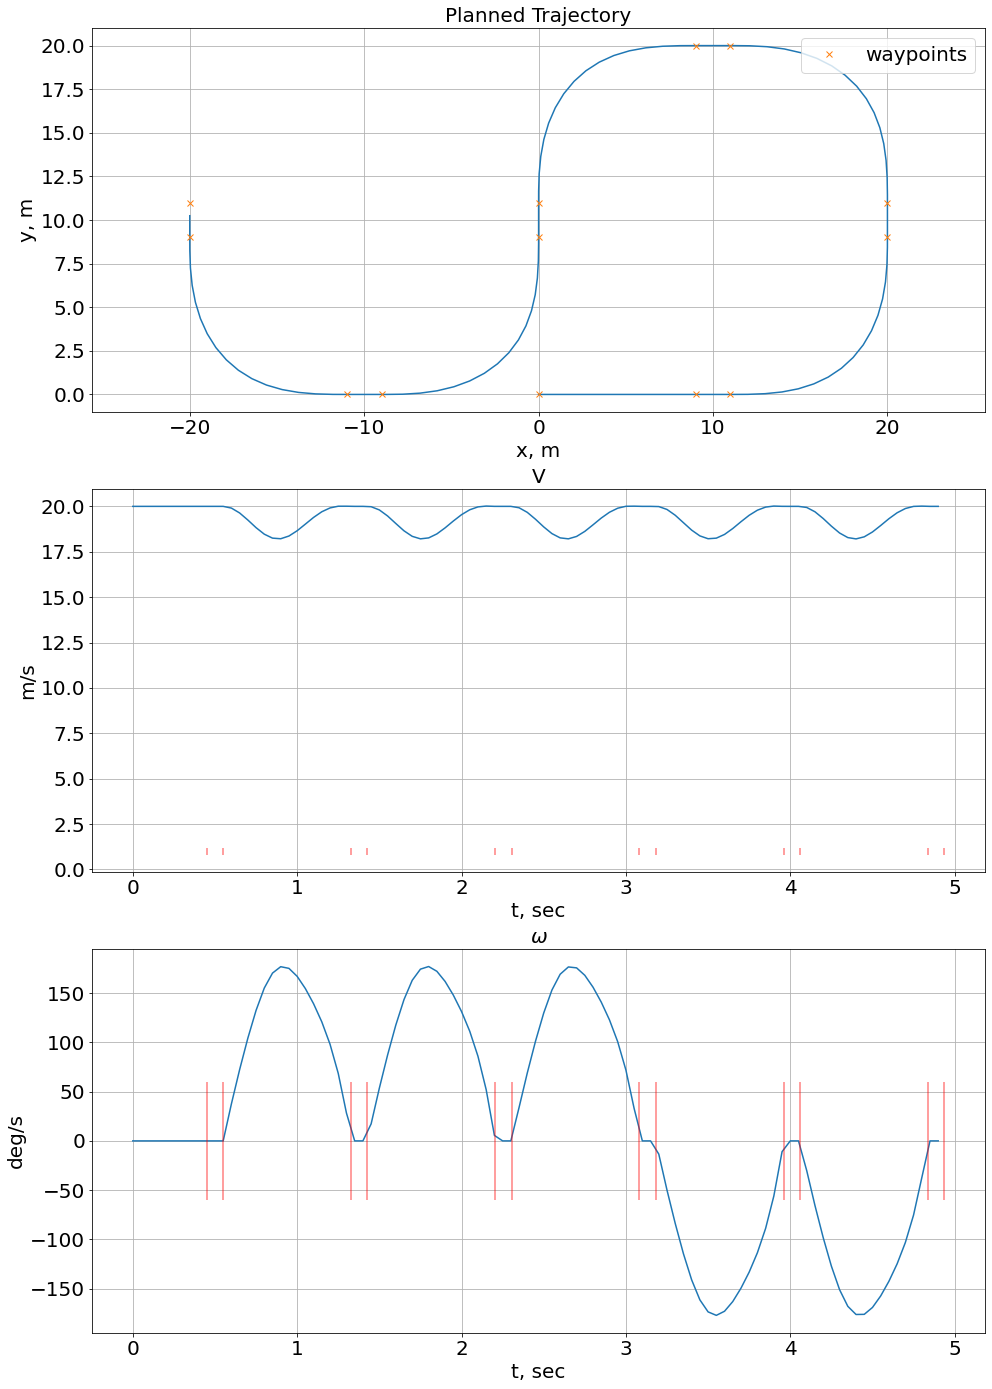

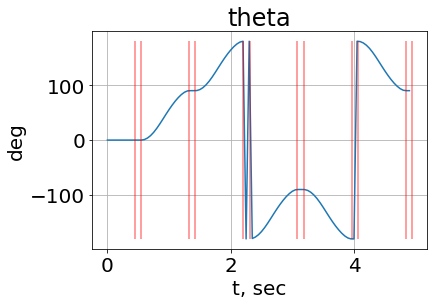

In [3]:
v  = 20
r = 9
planner = RoverPlanner(x=0, y=0, v=v, theta=0, r=r)
# planner.goto(15, 0, v, r)
planner.goto(20, 0, v, r)
# planner.goto(30, 15, v, r)
planner.goto(20, 20, v, r)
planner.goto(0, 20, v, r)
planner.goto(0, 0, v, r)
planner.goto(-20, 0, v, r)
planner.goto(-20, 20, v, r)
# planner.goto(0, 6, v, r)
# planner.goto(0, 12, v, r)
# planner.goto(6, 12, v, r)
# planner.goto(6, 6, v, r)
# planner.goto(-6, 6, v, r)
# planner.goto(-6, 12, v, r)
#planner.stop(-100, 100)

ref_data = planner.compute_ref_data(plot=True)
x_r = ref_data['way_points'][0,:]
y_r = ref_data['way_points'][1,:]
omega = ref_data['omega']
ref_theta = ref_data['theta']    

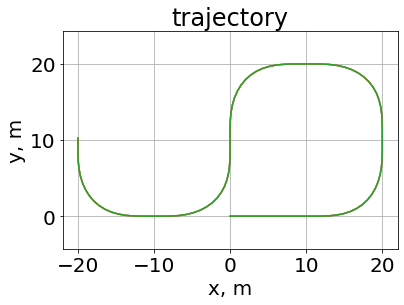

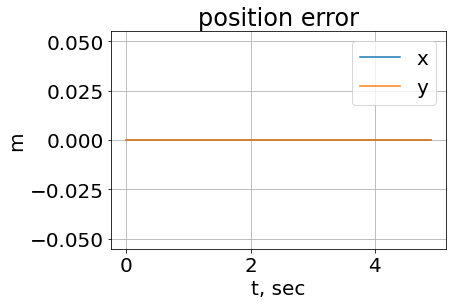

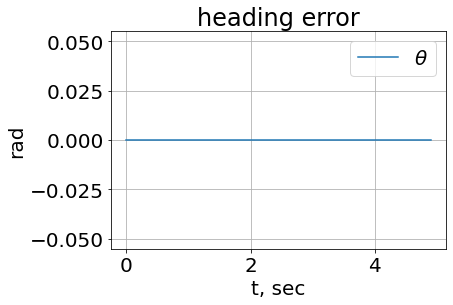

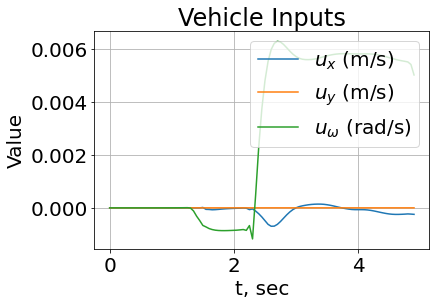

In [4]:
vr = 20
# res = simulate_rover(planner, freq_d=.015, w1=0.1, w2=0.1, x0=0, y0=0, theta0=np.pi/100, dist='sine', dt=.05, use_approx=False)
res = simulate_rover(planner, freq_d=.01, w1=0, w2=0, x0=0, y0=0, theta0=0, vr=20, dist='square', case='', dt=.05, use_approx=False)
err = plot_rover_sim(res=res, vr=vr, case='', planner=planner)

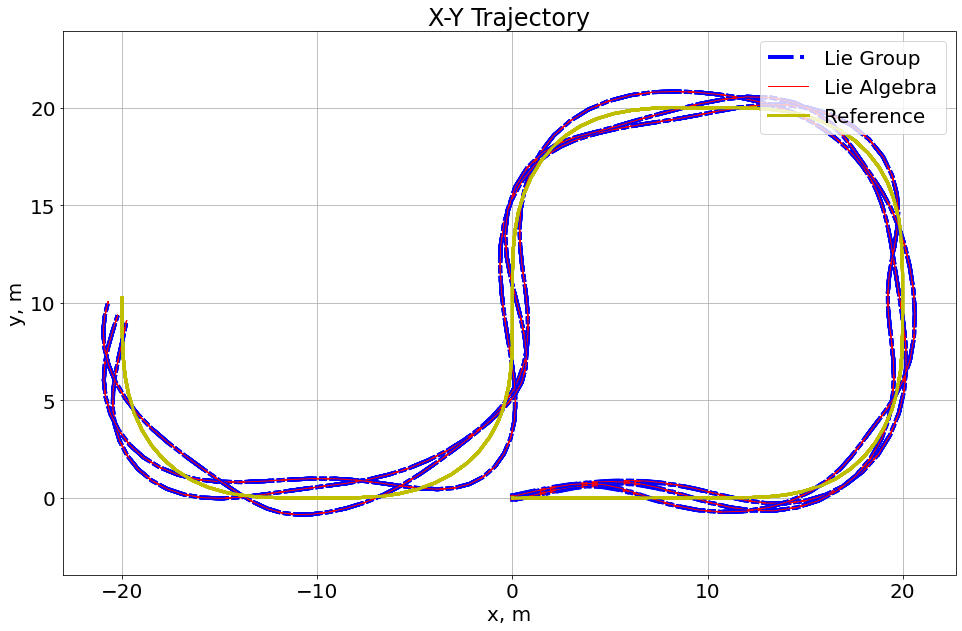

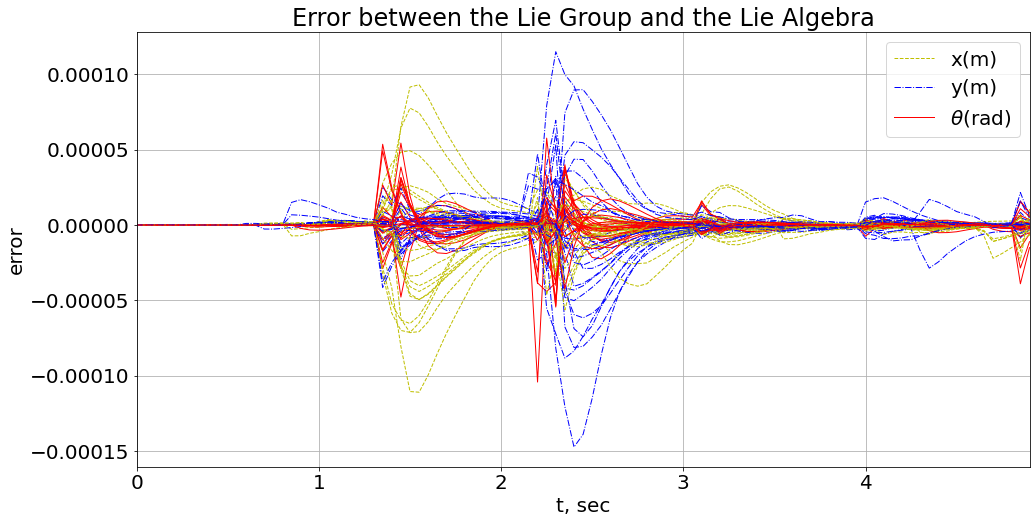

In [689]:
freq = [0.7, 0.9, 1.3]#, .04, .06, .08] # freq = 0.02 not happy with L=diag([1,0,1])
res = []
t = 40
# disturbances
w1 = 5
w2 = .1
vr = 20

cnt = 0
for theta0 in np.linspace(-np.pi/100, np.pi/100, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
            cnt += 1
            for i, f in enumerate(freq):
                res = simulate_rover(planner, f, w1, w2, x0, y0, theta0, vr, dist='sine', case='', dt=.05, use_approx = False)
                legend = cnt == 1 and f == freq[-1]
                fig1, fig2, _ = plot_sim_corres(res, planner, name='', legend=legend, save=False)
                
fig1.savefig('figures/Lie_corres.eps', format='eps', bbox_inches='tight')
fig2.savefig('figures/Lie_error1.eps', format='eps', bbox_inches='tight')

# Invariant Set

In [150]:
w1 = 5# small: 1 large: 5 (m/s)
w2 = .1 
e = np.array([.1,.1,np.pi/100]) # Lie Group
e0 = SE2(e[0], e[1], e[2]).log.vee # Lie Algebra
print(e0)
t = 0
sol = find_se2_invariant_set(-np.pi, np.pi, 18, 20, e='', case='')
P = sol['P']
beta = (e0.T@P@e0)

[0.10156257 0.09842098 0.03141593]


In [151]:
w1_new = iteration(w1, w2, 0, 0, beta, t, sol)
print(w1_new)

5.0152431500041414


In [152]:
points, _ = se2_lie_algebra_invariant_set_points(sol, 4, w1_new, w2, beta) #Lie Algebra
inv_points = np.zeros((3,points.shape[1]))
for i in range(points.shape[1]):
    exp_points = se2(points[0,i], points[1,i], points[2,i]).exp
    inv_points[:,i] = np.array([exp_points.x, exp_points.y, exp_points.theta])

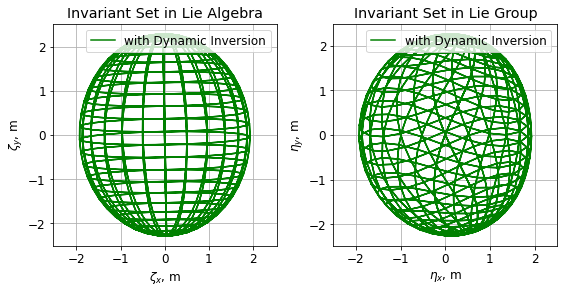

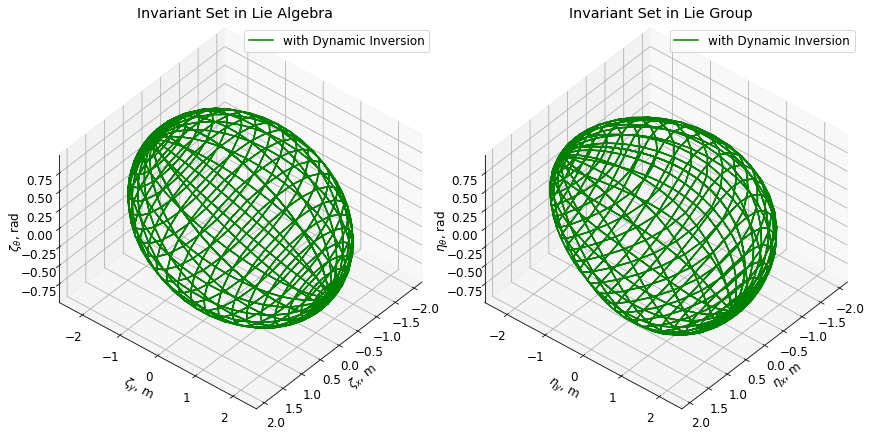

In [154]:
plt.figure(figsize=(8,4))
plt.rcParams.update({'font.size': 12})
ax = plt.subplot(121)
ax.plot(points[0, :], points[1, :], 'g', label='with Dynamic Inversion')
# ax.plot(pointscl[0, :], pointscl[1, :], 'b', linewidth=0.5, label='without Dynamic Inversion')
ax.set_xlabel('$\\zeta_x$, m')
ax.set_ylabel('$\\zeta_y$, m')
# ax.plot(xopt.x,xopt.y,'ro')
plt.axis('equal')
plt.grid(True)
plt.legend(loc=1)
ax2 = plt.subplot(122)
ax2.plot(inv_points[0, :-1], inv_points[1, :-1], 'g', label='with Dynamic Inversion')
# ax2.plot(inv_pointscl[0, :-1], inv_pointscl[1, :-1], 'b', linewidth=0.5, label='without Dynamic Inversion')
# ax2.plot(e[0],e[1],'ro')
ax2.set_xlabel('$\\eta_x$, m')
ax2.set_ylabel('$\\eta_y$, m')
plt.grid(True)
plt.legend(loc=1)
plt.axis('equal')
plt.tight_layout()
ax.set_title('Invariant Set in Lie Algebra')
ax2.set_title('Invariant Set in Lie Group')
plt.savefig('figures/Invariant_l.eps', format='eps', bbox_inches='tight')


plt.figure(figsize=(12,6))
ax = plt.subplot(121, projection='3d', proj_type='ortho', elev=40, azim=40)
# ax.plot3D(e0[0], e0[1], e0[2], 'ro');
ax.plot3D(points[0, :], points[1, :], points[2, :],'g', label='with Dynamic Inversion')
# ax.plot3D(pointscl[0, :], pointscl[1, :], pointscl[2, :],'b', linewidth=0.5, label='without Dynamic Inversion')
ax.set_xlabel('$\\zeta_x$, m')
ax.set_ylabel('$\\zeta_y$, m')
ax.set_zlabel('$\\zeta_\\theta$, rad')
ax.set_title('Invariant Set in Lie Algebra')
plt.axis('auto')
plt.legend(loc=1)
ax2 = plt.subplot(122, projection='3d', proj_type='ortho', elev=40, azim=40)
# ax2.plot3D(e[0], e[1], e[2], 'ro');
ax2.plot3D(inv_points[0, :], inv_points[1, :], inv_points[2, :], 'g', label='with Dynamic Inversion')
# ax2.plot3D(inv_pointscl[0, :], inv_pointscl[1, :], inv_pointscl[2, :], 'b', linewidth=0.5, label='without Dynamic Inversion')
# ax2.plot3D(e[0], e[1], e[2], 'ro');
ax2.set_xlabel('$\\eta_x$, m')
ax2.set_ylabel('$\\eta_y$, m')
ax2.set_zlabel('$\\eta_\\theta$, rad')
ax2.set_title('Invariant Set in Lie Group')
plt.axis('auto')
plt.legend(loc=1)
plt.tight_layout()
plt.savefig('figures/Invariant3d_l.eps', format='eps', bbox_inches='tight')

find saturation input

In [103]:
def fun(x):
    e = se2(x[0], x[1], x[2])
    return control_law(B, K, e, case='')[0]

def const(x):
    return x.T@P@x - val

cons = {'type':'eq', 'fun': const}


In [104]:
B, K = solve_control_gain(vr)
P = sol['P']
beta = (e0.T@P@e0)
t = 5
val = np.real(beta*np.exp(-sol['alpha']*t) + (sol['mu1']*w1_new**2 + sol['mu2']*w2**2)*(1-np.exp(-sol['alpha']*t)))
print(val)

5.549501138972088


In [105]:
opt = scipy.optimize.minimize(fun, x0=np.array([0,0,0]), constraints=cons)['x']
xopt = se2(opt[0], opt[1], opt[2])
uopt = control_law(B,K,xopt, case='')
print(uopt)


[-5.4239366   0.03300104  0.48275761]


comparision with HJ

0.4650829322735103


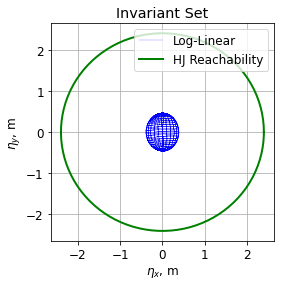

In [117]:
r= 2.4 #2.4 #0.75
hj_points = hj_invariant_set_points(r)
dist = np.zeros((inv_points.shape[1]))
for i in range(inv_points.shape[1]):
    dist[i] = np.sqrt(inv_points[1,i]**2 + inv_points[0,i]**2)
swept_points = hj_invariant_set_points(dist.max())
print(dist.max())

plt.figure(figsize=(4,4))
plt.rcParams.update({'font.size': 12})
plt.plot(inv_points[0, :], inv_points[1, :], 'b', linewidth=0.2, label='Log-Linear');
plt.plot(hj_points[0, :], hj_points[1, :], 'g', linewidth=2, label='HJ Reachability');
plt.legend(loc=1)
plt.xlabel('$\\eta_x$, m')
plt.ylabel('$\\eta_y$, m')
plt.title('Invariant Set')
plt.grid()
plt.savefig('figures/HJ_log_s.eps', format='eps', bbox_inches='tight')

# ax.hlines(-1.7, -1.5, 1.5)
#ax.plot(e0[0],e0[1],'ro')
# ax.set_xlim([-3,3])
# ax.set_ylim([-3,3])
# plt.grid(True)
# ax2 = plt.subplot(122)
# ax2.plot(hj_points[0, :], hj_points[1, :], 'g', label='HJ Reachability');
# ax2.plot(swept_points[0, :], swept_points[1, :], 'b', label='LMI');
# #ax2.plot(e[0],e[1],'ro')
# ax2.legend(loc=1)
# ax2.set_xlabel('$e_x$')
# ax2.set_ylabel('$e_y$')
# plt.grid(True)
# plt.tight_layout()
# ax.set_title('Invariant Set')
# ax2.set_title('Invariant Set')

different controller

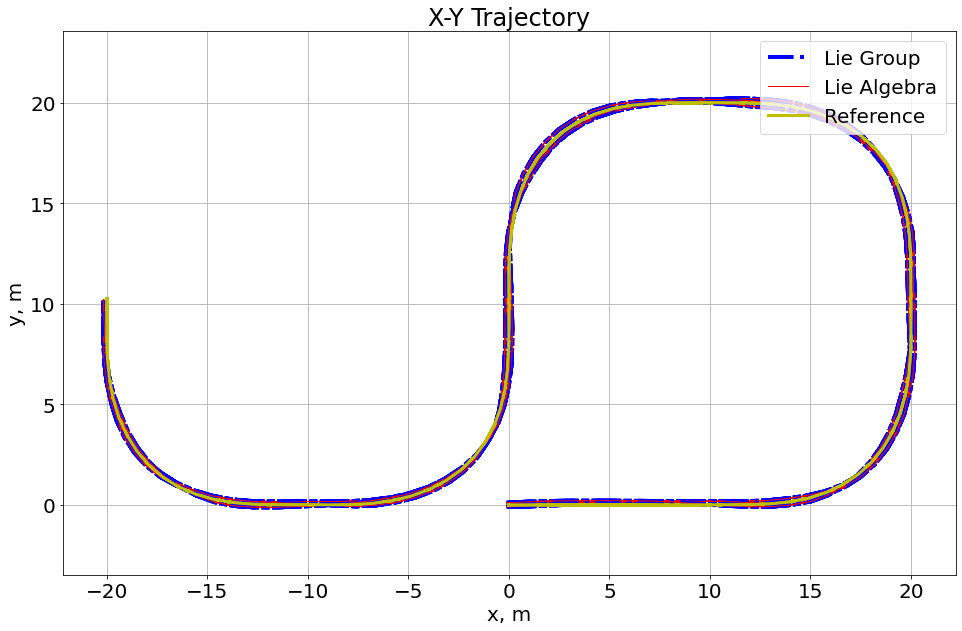

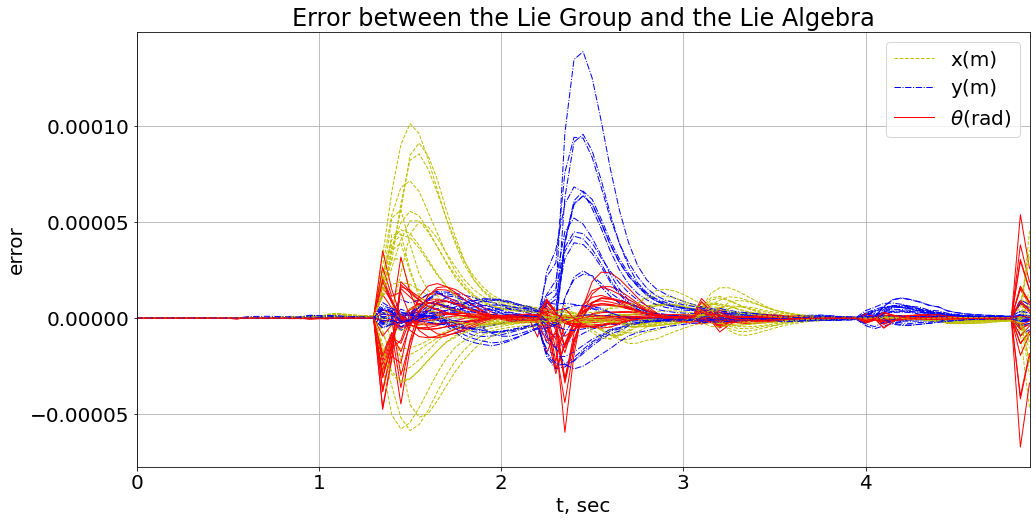

In [40]:
freq = [0.7, 0.9, 1.3]#, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]#, 0.9, 1.3]#, .04, .06, .08] # freq = 0.02 not happy with L=diag([1,0,1])
res = []
t = 40
# disturbances
w1s = 1
w2 = .1
e = np.array([[],[],[]])
vr = 20

cnt = 0
for theta0 in np.linspace(-np.pi/100, np.pi/100, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
            cnt += 1
            for i, f in enumerate(freq):
                res = simulate_rover(planner, freq_d=f, w1=w1s, w2=w2, x0=x0, y0=y0, theta0=theta0, vr=vr, dist='square', case='no_side', dt=.05, use_approx=False)
                legend = cnt == 1 and f == freq[-1]
                fig1, fig2, err = plot_sim_corres(res, planner, name='', legend=legend, save=False)
                es = np.append(e, err, axis=1)

# fig1.savefig('Lie_corres.eps', format='eps', bbox_inches='tight')
# fig2.savefig('Lie_error2.eps', format='eps', bbox_inches='tight')

In [41]:
B, K, BK = solve_control_gain(20)
u12 = []
u3 = []
for i in range(es.shape[1]):
    e = se2(es[0][i],es[1][i],es[2][i])
    U = se2_diff_correction(e)
    u = (U-np.eye(3))@BK@e.vee
    u12_norm = np.sqrt(u[0]**2 + u[1]**2)
    u12.append(u12_norm)
    u3.append(np.abs(u[2]))


In [130]:
w1 = 1# small: 1 large: 5 (m/s)
w2 = .1 
e = np.array([.1,.1,np.pi/100]) # Lie Group
e0 = SE2(e[0], e[1], e[2]).log.vee # Lie Algebra
print(e0)
t = 0
sol = find_se2_invariant_set(-np.pi, np.pi, 18, 20, e='', case='')
P = sol['P']
beta = (e0.T@P@e0)

[0.10156257 0.09842098 0.03141593]


In [131]:
w1_new = iteration(w1, w2, max(u12), max(u3), beta, t, sol)
print(w1_new)

1.0141473954650508


In [132]:
pointscs, _ = se2_lie_algebra_invariant_set_points(sol, 10, w1_new+max(u12), w2+max(u3), beta) #Lie Algebra
inv_pointscs = np.zeros((3,points.shape[1]))
for i in range(pointscs.shape[1]):
    exp_points = se2(pointscs[0,i], pointscs[1,i], pointscs[2,i]).exp
    inv_pointscs[:,i] = np.array([exp_points.x, exp_points.y, exp_points.theta])

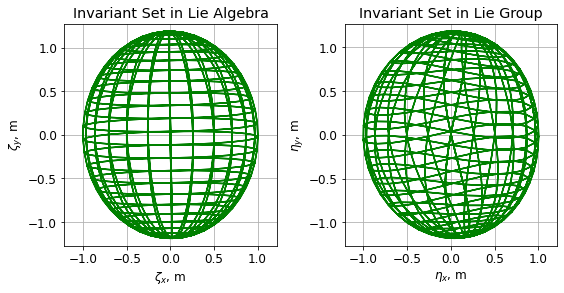

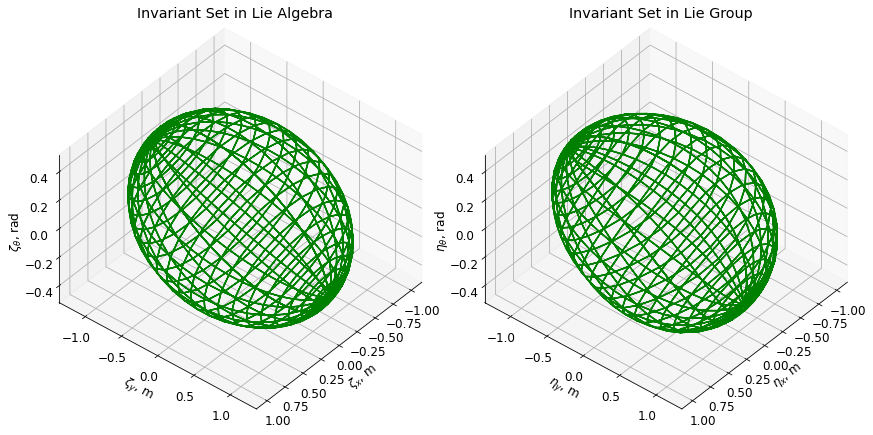

In [133]:
plt.figure(figsize=(8,4))
plt.rcParams.update({'font.size': 12})
ax = plt.subplot(121)
ax.plot(pointscs[0, :], pointscs[1, :], 'g')
ax.set_xlabel('$\\zeta_x$, m')
ax.set_ylabel('$\\zeta_y$, m')
# ax.plot(xopt.x,xopt.y,'ro')
plt.axis('equal')
plt.grid(True)
ax2 = plt.subplot(122)
ax2.plot(inv_pointscs[0, :-1], inv_pointscs[1, :-1], 'g')
# ax2.plot(e[0],e[1],'ro')
ax2.set_xlabel('$\\eta_x$, m')
ax2.set_ylabel('$\\eta_y$, m')
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
ax.set_title('Invariant Set in Lie Algebra')
ax2.set_title('Invariant Set in Lie Group')
plt.savefig('figures/Invariant_cs.eps', format='eps', bbox_inches='tight')


plt.figure(figsize=(12,6))
ax = plt.subplot(121, projection='3d', proj_type='ortho', elev=40, azim=40)
# ax.plot3D(e0[0], e0[1], e0[2], 'ro');
ax.plot3D(pointscs[0, :], pointscs[1, :], pointscs[2, :],'g');
ax.set_xlabel('$\\zeta_x$, m')
ax.set_ylabel('$\\zeta_y$, m')
ax.set_zlabel('$\\zeta_\\theta$, rad')
ax.set_title('Invariant Set in Lie Algebra')
plt.axis('auto')
ax2 = plt.subplot(122, projection='3d', proj_type='ortho', elev=40, azim=40)
# ax2.plot3D(e[0], e[1], e[2], 'ro');
ax2.plot3D(inv_pointscs[0, :], inv_pointscs[1, :], inv_pointscs[2, :], 'g');
# ax2.plot3D(e[0], e[1], e[2], 'ro');
ax2.set_xlabel('$\\eta_x$, m')
ax2.set_ylabel('$\\eta_y$, m')
ax2.set_zlabel('$\\eta_\\theta$, rad')
ax2.set_title('Invariant Set in Lie Group')
plt.axis('auto')
plt.tight_layout()
plt.savefig('figures/Invariant3d_cs.eps', format='eps', bbox_inches='tight')

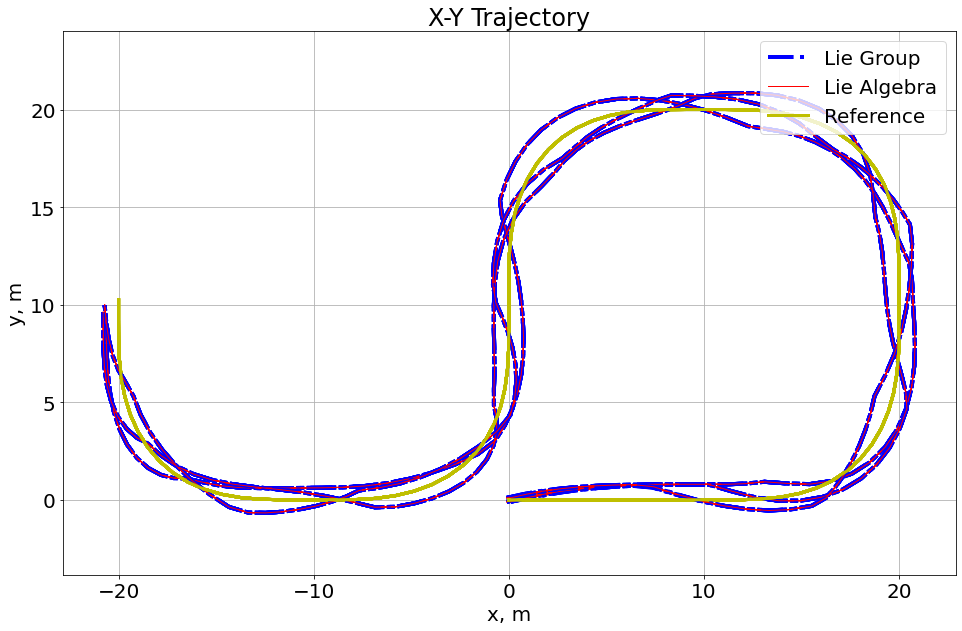

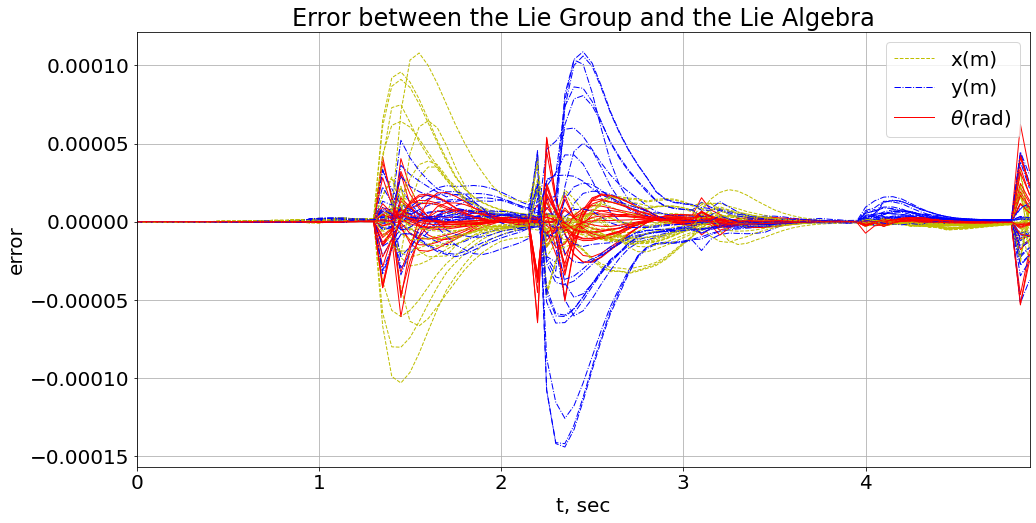

In [46]:
freq = [0.7, 0.9, 1.3]#, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]#, 0.9, 1.3]#, .04, .06, .08] # freq = 0.02 not happy with L=diag([1,0,1])
res = []
t = 40
# disturbances
w1l = 5
w2 = .1
e = np.array([[],[],[]])
vr = 20

cnt = 0
for theta0 in np.linspace(-np.pi/100, np.pi/100, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
            cnt += 1
            for i, f in enumerate(freq):
                res = simulate_rover(planner, freq_d=f, w1=w1l, w2=w2, x0=x0, y0=y0, theta0=theta0, vr=vr, dist='square', case='no_side', dt=.05, use_approx=False)
                legend = cnt == 1 and f == freq[-1]
                fig1, fig2, err = plot_sim_corres(res, planner, name='', legend=legend, save=False)
                el = np.append(e, err, axis=1)

# fig1.savefig('Lie_corres.eps', format='eps', bbox_inches='tight')
# fig2.savefig('Lie_error2.eps', format='eps', bbox_inches='tight')

In [47]:
B, K, BK = solve_control_gain(20)
u12l = []
u3l = []
for i in range(el.shape[1]):
    e = se2(el[0][i],el[1][i],el[2][i])
    U = se2_diff_correction(e)
    u = (U-np.eye(3))@BK@e.vee
    u12_norm = np.sqrt(u[0]**2 + u[1]**2)
    u12l.append(u12_norm)
    u3l.append(np.abs(u[2]))


In [127]:
w1l = 5# small: 1 large: 5 (m/s)
w2 = .1 
e = np.array([.1,.1,np.pi/100]) # Lie Group
e0 = SE2(e[0], e[1], e[2]).log.vee # Lie Algebra
t = 0
sol = find_se2_invariant_set(-np.pi, np.pi, 18, 20, e='', case='')
P = sol['P']
beta = (e0.T@P@e0)

In [49]:
w1l_new = iteration(w1l, w2, max(u12l), max(u3l), beta, t, sol)
print(w1l_new)

5.0152431500041414


In [128]:
pointscl, _ = se2_lie_algebra_invariant_set_points(sol, 10, w1l_new+max(u12l), w2+max(u3l), beta) #Lie Algebra
inv_pointscl = np.zeros((3,points.shape[1]))
for i in range(pointscl.shape[1]):
    exp_points = se2(pointscl[0,i], pointscl[1,i], pointscl[2,i]).exp
    inv_pointscl[:,i] = np.array([exp_points.x, exp_points.y, exp_points.theta])

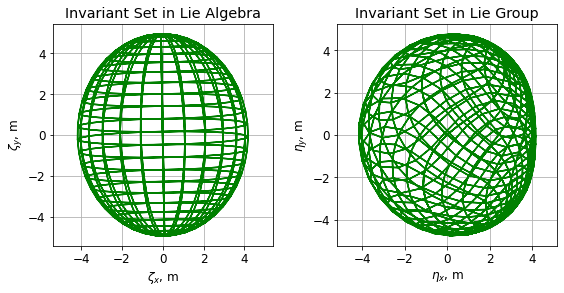

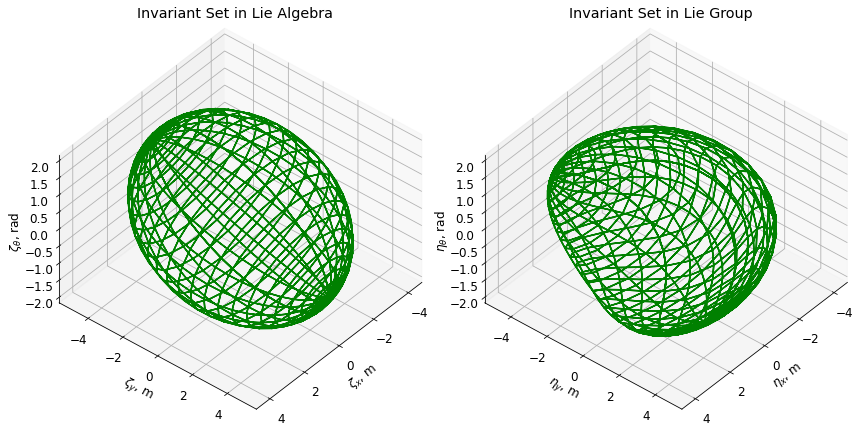

In [129]:
plt.figure(figsize=(8,4))
plt.rcParams.update({'font.size': 12})
ax = plt.subplot(121)
ax.plot(pointscl[0, :], pointscl[1, :], 'g')
ax.set_xlabel('$\\zeta_x$, m')
ax.set_ylabel('$\\zeta_y$, m')
# ax.plot(xopt.x,xopt.y,'ro')
plt.axis('equal')
plt.grid(True)
ax2 = plt.subplot(122)
ax2.plot(inv_pointscl[0, :-1], inv_pointscl[1, :-1], 'g')
# ax2.plot(e[0],e[1],'ro')
ax2.set_xlabel('$\\eta_x$, m')
ax2.set_ylabel('$\\eta_y$, m')
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
ax.set_title('Invariant Set in Lie Algebra')
ax2.set_title('Invariant Set in Lie Group')
plt.savefig('figures/Invariant_cl.eps', format='eps', bbox_inches='tight')


plt.figure(figsize=(12,6))
ax = plt.subplot(121, projection='3d', proj_type='ortho', elev=40, azim=40)
# ax.plot3D(e0[0], e0[1], e0[2], 'ro');
ax.plot3D(pointscl[0, :], pointscl[1, :], pointscl[2, :],'g');
ax.set_xlabel('$\\zeta_x$, m')
ax.set_ylabel('$\\zeta_y$, m')
ax.set_zlabel('$\\zeta_\\theta$, rad')
ax.set_title('Invariant Set in Lie Algebra')
plt.axis('auto')
ax2 = plt.subplot(122, projection='3d', proj_type='ortho', elev=40, azim=40)
# ax2.plot3D(e[0], e[1], e[2], 'ro');
ax2.plot3D(inv_pointscl[0, :], inv_pointscl[1, :], inv_pointscl[2, :], 'g');
# ax2.plot3D(e[0], e[1], e[2], 'ro');
ax2.set_xlabel('$\\eta_x$, m')
ax2.set_ylabel('$\\eta_y$, m')
ax2.set_zlabel('$\\eta_\\theta$, rad')
ax2.set_title('Invariant Set in Lie Group')
plt.axis('auto')
plt.tight_layout()
plt.savefig('figures/Invariant3d_cl.eps', format='eps', bbox_inches='tight')

# Flow Pipes Simulation

In [5]:
n = 44# number of interval hulls
# disturbances
w1s = 1
w1l = 5
# sol_s = find_se2_invariant_set() # u, v, w1, w2

e0 = SE2(.1, .1, np.pi/100).log.vee

flow_pipes_LMI1, intervalhull_LMI, nom, t_vect, bound_y1, bound_y2 = flowpipes(planner, n, beta, w1s, w2, sol)

In [6]:
flow_pipes_LMI2, intervalhull_LMI, nom, t_vect, bound_y1l, bound_y2l = flowpipes(planner, n, beta, w1l, w2, sol)

Text(0, 0.5, 'y')

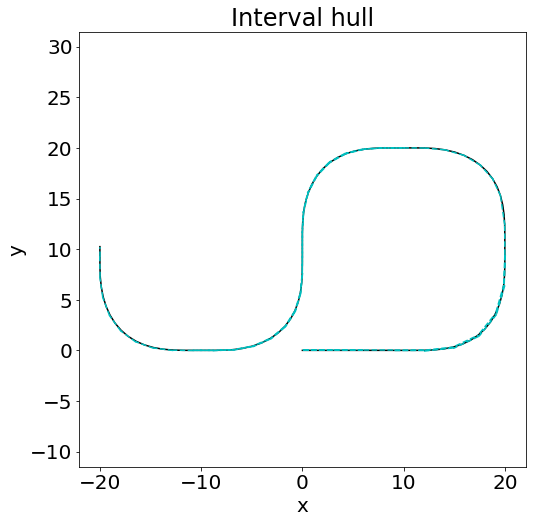

In [7]:
# interval hull
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
h_nom = ax.plot(nom[:,0], nom[:,1], color='k', linestyle='-')
for facet in range(44):
    hs_ch_LMI = ax.plot(intervalhull_LMI[facet][:,0], intervalhull_LMI[facet][:,1], color='c', linestyle='--')

plt.axis('equal')
plt.title('Interval hull')
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

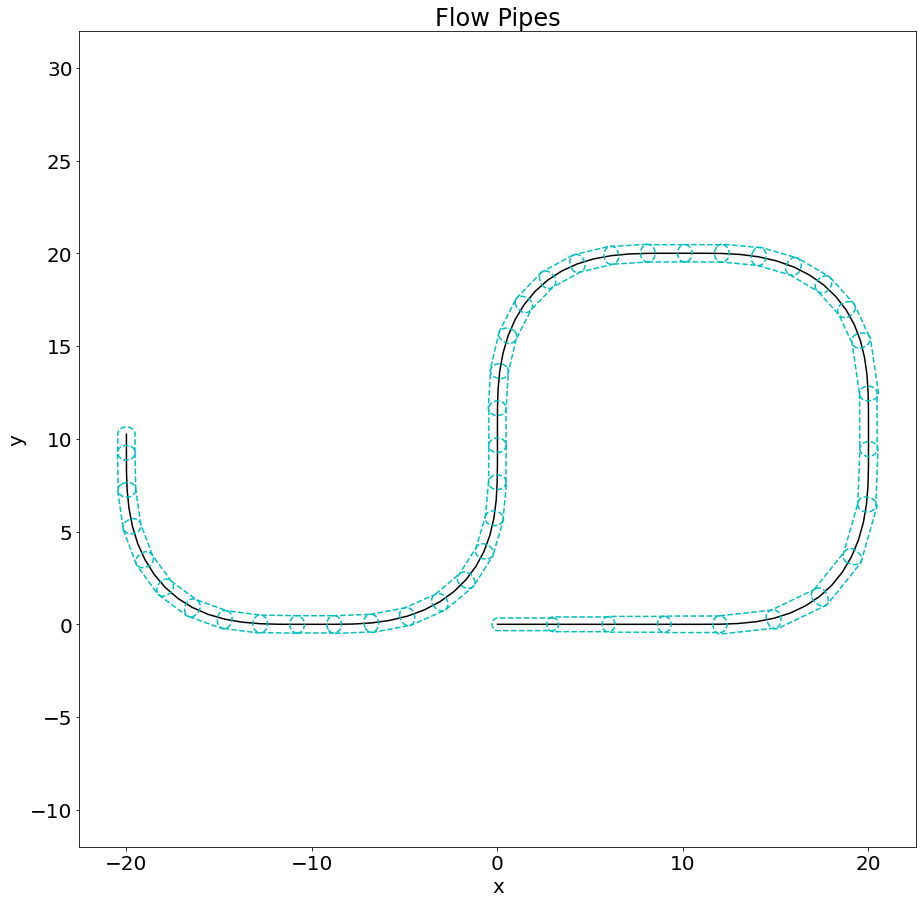

In [409]:
# flow pipes
plt.figure(figsize=(15,15))
ax = plt.subplot(111)
h_nom = ax.plot(nom[:,0], nom[:,1], color='k', linestyle='-')
for facet in range(n):
    hs_ch_LMI = ax.plot(flow_pipes_LMI1[facet][:,0], flow_pipes_LMI1[facet][:,1], color='c', linestyle='--')
    #hs_ch_LMI_L = ax.plot(flow_pipes_LMI_L[facet][:,0], flow_pipes_LMI_L[facet][:,1], color='y', linestyle='--')
    #hs_ch_Hs = ax.plot(flow_pipes_Hs[facet][:,0], flow_pipes_Hs[facet][:,1], color='m', linestyle='--', alpha = 0.5)

plt.axis('equal')
plt.title('Flow Pipes')
plt.xlabel('x')
plt.ylabel('y')
#legend([h_nom[0], hs_ch_LMI[0], hs_ch_LMI_L[0]], ['nominal', 'flow pipe (small)', 'flow pipe (Large)'], loc=1);

Text(0, 0.5, 'y')

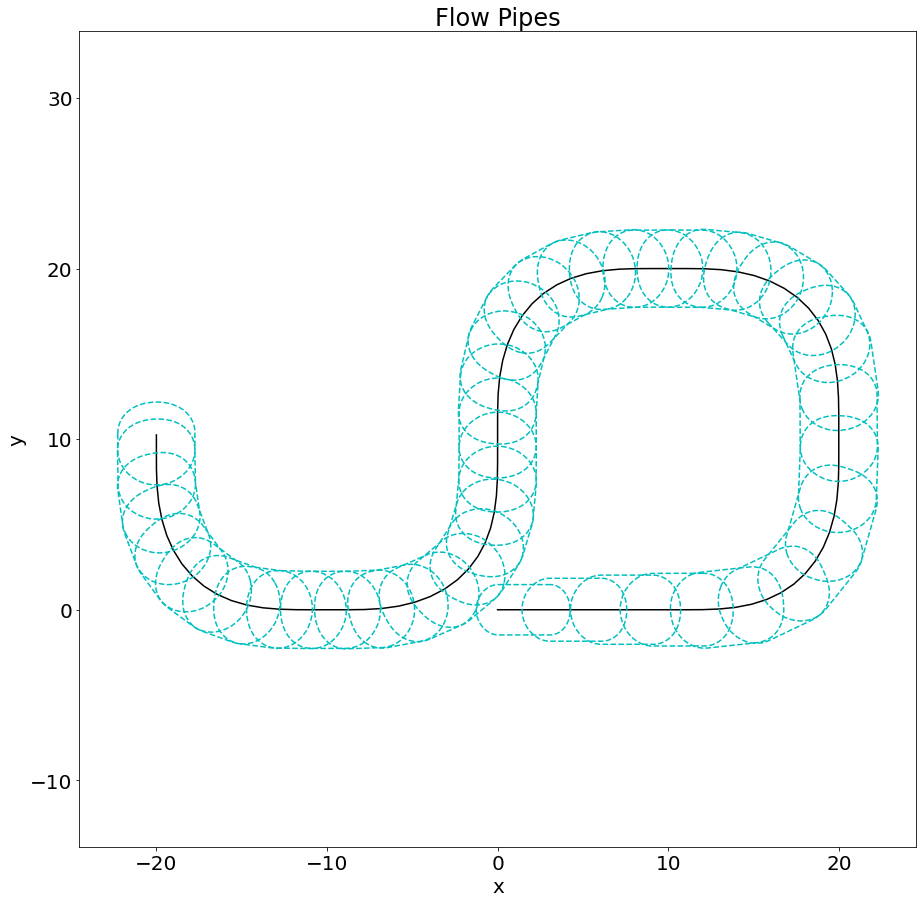

In [408]:
# flow pipes
plt.figure(figsize=(15,15))
ax = plt.subplot(111)
h_nom = ax.plot(nom[:,0], nom[:,1], color='k', linestyle='-')
for facet in range(n):
    hs_ch_LMI = ax.plot(flow_pipes_LMI2[facet][:,0], flow_pipes_LMI2[facet][:,1], color='c', linestyle='--')
    #hs_ch_LMI_L = ax.plot(flow_pipes_LMI_L[facet][:,0], flow_pipes_LMI_L[facet][:,1], color='y', linestyle='--')
    #hs_ch_Hs = ax.plot(flow_pipes_Hs[facet][:,0], flow_pipes_Hs[facet][:,1], color='m', linestyle='--', alpha = 0.5)

plt.axis('equal')
plt.title('Flow Pipes')
plt.xlabel('x')
plt.ylabel('y')
#legend([h_nom[0], hs_ch_LMI[0], hs_ch_LMI_L[0]], ['nominal', 'flow pipe (small)', 'flow pipe (Large)'], loc=1);


# Trajectories simulation with flow pipe

In [410]:
V2 = np.array([[0, 0], [2, 0], [2, 2], [0, 2]])
P2 = Polytope(V2)
p4 = (17, 8)
P3 = P2*1.5 + (-4,5)
P4 = P2 + p4

P5 = 1.5*P3 - (7, 6.8)


[[-0.1       ]
 [-0.1       ]
 [-0.03141593]]
[-0.09842098 -0.10156257 -0.03141593]


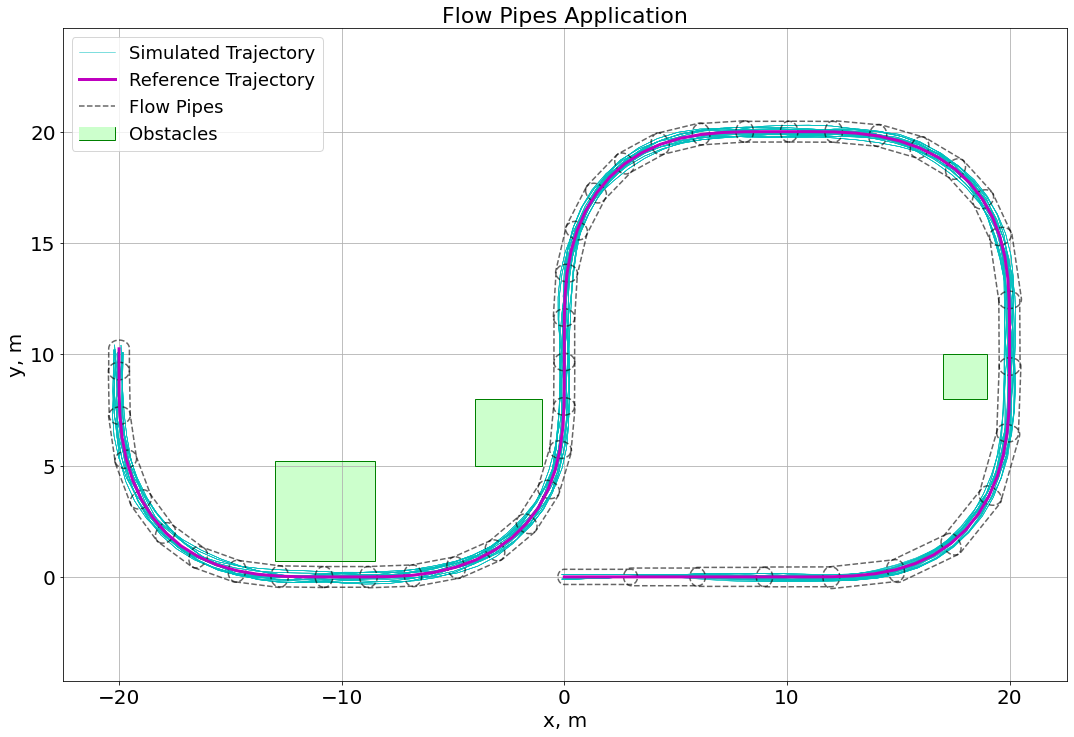

In [411]:
# small distrubance
freq = [0.5, 0.7, 0.9, 1, 1.1, 1.3, 1.5]#, 1.2, 1.3, 1.4, 1.5]#,0.04,0.05
e = []
V = []
# number of interval hulls
# disturbances

cnt = 0
for theta0 in np.arange(-np.pi/100, np.pi/100, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
            cnt += 1
            init_e = np.array([[x0, y0, theta0]]).T
            V0 = init_e.T@sol['P']@init_e
            V.append(V0)
            e.append(init_e)
            for i, f in enumerate(freq):
                res = simulate_rover(planner, f, w1s, w2, x0, y0, theta0, vr, dist='sine', case='', dt=0.05, use_approx = False)
                res1 = simulate_rover(planner, f, w1s, w2, x0, y0, theta0, vr, dist='square', case='', dt=0.05, use_approx = False)
                legend = cnt == 1 and i == 0
                plot_rover_simulated(res, planner, name='', legend=legend, save=False, linewidth = .5, color = 'c')
                plot_rover_simulated(res1, planner, name=' in square wave', legend=False, save=False, linewidth = .5, color = 'c')
                #if i == len(freq) - 1:
                    #r3 = simulate_rover(planner, f, w1, w2, 0, 0, theta0, dist='maxdV', sol= sol_s)
                    #plot_rover_simulated(r3, name='maxdV', legend= (cnt == 1), save=False, linewidth = 1, color = 'r')

i = np.array(V).argmax()
print(e[i])
e0 = SE2(e[i][0], e[i][1], e[i][2]).log.vee
print(e0)
# n, flow_pipes_LMI, intervalhull_LMI, nom = flowpipes_traj(planner, res1, x_r, y_r, n, e0, w1, w2)
# n_hull, flow_pipes_hj, intervalhull, nom = flowpipeshj(x_r, y_r, n, e0, w1, w2, 2.4)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI1[facet][:,0], flow_pipes_LMI1[facet][:,1], color='k', linestyle='--', alpha = 0.6)

obs = P4.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)
P3.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)
P5.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)

h_nom = plt.plot(nom[:,0], nom[:,1], linewidth = 3, color='m', linestyle='-')

plt.axis('equal')
plt.title('Flow Pipes Application', fontsize=22)
plt.xlabel('x, m', fontsize=20)
plt.ylabel('y, m', fontsize=20)

lgd = plt.legend(loc=2, prop={'size': 18})
ax = lgd.axes
handles, labels = ax.get_legend_handles_labels()
handles.append(h_nom[0])
labels.append('Reference Trajectory')
handles.append(hs_ch_LMI[0])
labels.append('Flow Pipes')
handles.append(obs)
labels.append('Obstacles')
lgd._legend_box = None
lgd._init_legend_box(handles, labels)
lgd._set_loc(lgd._loc)
lgd.set_title(lgd.get_title().get_text())
plt.savefig('figures/flowpipe_s.eps', format='eps', bbox_inches='tight')


[[-0.1       ]
 [-0.1       ]
 [-0.03141593]]
[-0.09842098 -0.10156257 -0.03141593]


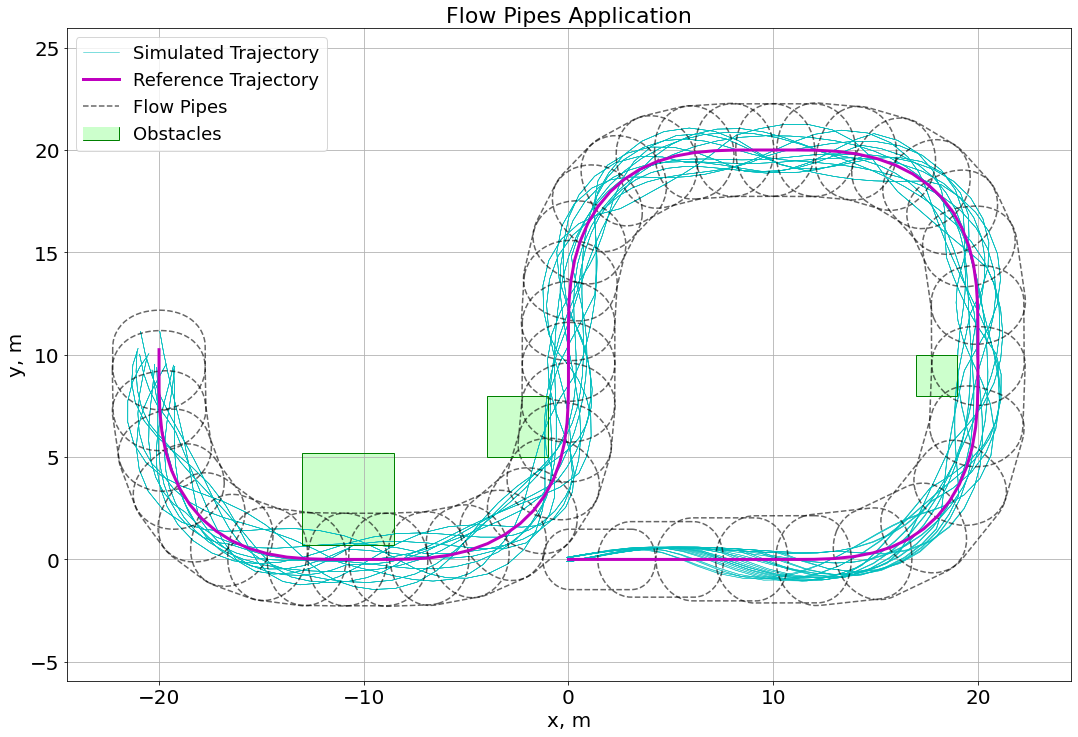

In [412]:
# large distrubance
# 0.04 0.1
freq = [0.5, 0.7, 0.9, 1, 1.1, 1.3, 1.5]#, 0.7, 0.9, 1.1, 1.3, 1.5]#0.04, 0.05, 0.08, 0.09]# [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]
e = []
V = []

cnt = 0
for theta0 in np.arange(-np.pi/100, np.pi/100, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
            cnt += 1
            init_e = np.array([[x0, y0, theta0]]).T
            V0 = init_e.T@sol['P']@init_e
            V.append(V0)
            e.append(init_e)
            for i, f in enumerate(freq):
                res = simulate_rover(planner, f, w1l, w2, x0, y0, theta0, vr, dist='sine', case='', dt=.05, use_approx = False)
                res1 = simulate_rover(planner, f, w1l, w2, x0, y0, theta0, vr, dist='square', case='', dt=.05, use_approx = False)
                legend = cnt == 1 and i == 0
                plot_rover_simulated(res, planner, name='', legend=legend, save=False, linewidth = .5, color = 'c')
                plot_rover_simulated(res1, planner, name=' in square wave', legend=False, save=False, linewidth = .5, color = 'c')
                

i = np.array(V).argmax()
print(e[i])
e0 = SE2(e[i][0], e[i][1], e[i][2]).log.vee
print(e0)
# n_hull, flow_pipes_hj, intervalhull, nom = flowpipeshj(x_r, y_r, n, e0, w1, w2, 0.7)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI2[facet][:,0], flow_pipes_LMI2[facet][:,1], color='k', linestyle='--', alpha = 0.6)

obs = P4.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)
P3.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)
P5.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)

h_nom = plt.plot(nom[:,0], nom[:,1], linewidth = 3, color='m', linestyle='-')
plt.axis('equal')
plt.title('Flow Pipes Application', fontsize=22)
plt.xlabel('x, m', fontsize=20)
plt.ylabel('y, m', fontsize=20)

lgd = plt.legend(loc=2, prop={'size': 18})
ax = lgd.axes
handles, labels = ax.get_legend_handles_labels()
handles.append(h_nom[0])
labels.append('Reference Trajectory')
handles.append(hs_ch_LMI[0])
labels.append('Flow Pipes')
handles.append(obs)
labels.append('Obstacles')
lgd._legend_box = None
lgd._init_legend_box(handles, labels)
lgd._set_loc(lgd._loc)
lgd.set_title(lgd.get_title().get_text())
plt.savefig('figures/flowpipe_l.eps', format='eps', bbox_inches='tight')


In [18]:
t_vect2 = np.linspace(0, 4.9, 99)
bounds = np.array([0.0432,0.0077,
    0.0843,
    0.1566,
    0.2201,
    0.2718,
    0.3104,
    0.3375,
    0.3549,
    0.3649,
    0.3709,
    0.3749,
    0.3882,
    0.4100,
    0.4376,
    0.4674,
    0.4960,
    0.5191,
    0.5351,
    0.5504,
    0.5616,
    0.5676,
    0.5672,
    0.5607,
    0.5483,
    0.5299,
    0.5045,
    0.4760,
    0.4478,
    0.4304,
    0.4269,
    0.4384,
    0.4615,
    0.4888,
    0.5148,
    0.5357,
    0.5521,
    0.5644,
    0.5732,
    0.5754,
    0.5705,
    0.5598,
    0.5433,
    0.5206,
    0.4917,
    0.4626,
    0.4377,
    0.4256,
    0.4299,
    0.4474,
    0.4734,
    0.5009,
    0.5250,
    0.5427,
    0.5583,
    0.5693,
    0.5752,
    0.5742,
    0.5665,
    0.5532,
    0.5340,
    0.5084,
    0.4797,
    0.4509,
    0.4315,
    0.4226,
    0.4276,
    0.4527,
    0.4814,
    0.5100,
    0.5330,
    0.5512,
    0.5660,
    0.5760,
    0.5786,
    0.5741,
    0.5635,
    0.5470,
    0.5245,
    0.4956,
    0.4661,
    0.4405,
    0.4270,
    0.4294,
    0.4457,
    0.4710,
    0.4985,
    0.5229,
    0.5411,
    0.5570,
    0.5683,
    0.5749,
    0.5746,
    0.5676,
    0.5548,
    0.5362,
    0.5113,
    0.4825,
    0.4534])

In [110]:
import scipy.io
b1 = scipy.io.loadmat('b1s.mat')
b2 = scipy.io.loadmat('b2s.mat')
b1l = scipy.io.loadmat('b1l.mat')
b2l = scipy.io.loadmat('b2l.mat')

In [111]:
b1s = b1['b'].reshape(99,)
b2s = b2['b2'].reshape(99,)
b1l = b1l['b1l'].reshape(99,)
b2l = b2l['b2l'].reshape(99,)


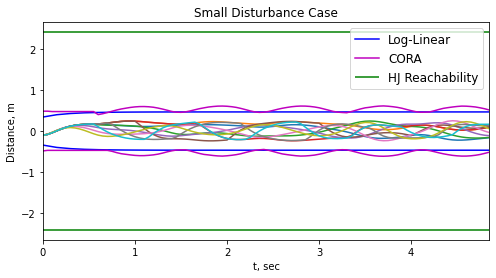

In [118]:
freq = [0.1, 0.3, 0.5, 0.7, 0.9]#, 1.1, 1.3, 1.5]
dist = ['sine', 'square']
w1s = 1
w2s = .1
plt.figure(figsize=(8,4))
for i, f in enumerate(freq):
    for d in dist:
        res = simulate_rover(planner, f, w1s, w2s, -0.1, -0.1, -np.pi/100, 20, case='', dist = d, dt=.05, use_approx = False)
        y_vect = res['y']
        x, y, theta, x_r, y_r, theta_r, log_e_x, log_e_y, log_e_theta = [y_vect[i, :] for i in range(len(y_vect))]
        err = np.array([compute_err(y[3], y[4], y[5], y[0], y[1], y[2]) for y in y_vect.T]).T
        err_y = err[1,:]
        err_x = err[0,:]
        plt.rcParams.update({'font.size': 10})
        plt.plot(res['t'], err_y)

plt.plot(t_vect, bound_y1, 'b', label='Log-Linear')
plt.plot(t_vect, bound_y2, 'b')
plt.plot(t_vect2, b1s, 'm')
plt.plot(t_vect2, b2s, 'm', label='CORA')
plt.hlines(2.4, 0, t_vect[-1], color='green', label='HJ Reachability')
plt.hlines(-2.4, 0, t_vect[-1], color='green')
plt.legend(loc=1, prop={'size': 12})
plt.xlim(0, t_vect[-1])
plt.xlabel('t, sec')
plt.ylabel('Distance, m')
plt.title('Small Disturbance Case')
plt.savefig('bound1.eps', format='eps', bbox_inches='tight')


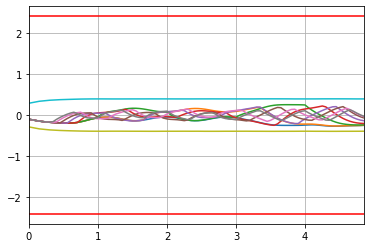

In [266]:
freq = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5]#, 0.03]#3, 0.04, 0.2, 0.02]#, 0.2, 0.7]#, 0.4]#, 0.05, 0.5]#, 0.08, 0.025]#, .02]#, .03]#, .05]#, .05, .07, .09]
dist = ['square']
w1s = 1
w2s = .1
for i, f in enumerate(freq):
    for d in dist:
        res = simulate_rover(planner, f, w1s, w2s, -0.1, -0.1, -np.pi/100, dist = d, dt=.05, use_approx = False)
        y_vect = res['y']
        x, y, theta, x_r, y_r, theta_r, log_e_x, log_e_y, log_e_theta = [y_vect[i, :] for i in range(len(y_vect))]
        err = np.array([compute_err(y[3], y[4], y[5], y[0], y[1], y[2]) for y in y_vect.T]).T
        err_x = err[0,:]
        plt.plot(res['t'], err_x)

# plt.plot(t_vect, Rx1s)
# plt.plot(t_vect, Rx2s)
plt.hlines(2.4, 0, t_vect[-1], color='red')
plt.hlines(-2.4, 0, t_vect[-1], color='red')
plt.xlim(0, t_vect[-1])
plt.grid()

In [16]:
bound = np.array([0.1630,
    0.4372,
    0.7260,
    0.9793,
    1.1879,
    1.3488,
    1.4637,
    1.5398,
    1.5854,
    1.6085,
    1.6232,
    1.6357,
    1.6984,
    1.8048,
    1.9413,
    2.0906,
    2.2358,
    2.3557,
    2.4409,
    2.5223,
    2.5812,
    2.6109,
    2.6067,
    2.5711,
    2.5066,
    2.4130,
    2.2855,
    2.1429,
    2.0029,
    1.9170,
    1.9001,
    1.9581,
    2.0734,
    2.2103,
    2.3421,
    2.4493,
    2.5350,
    2.5992,
    2.6431,
    2.6511,
    2.6233,
    2.5660,
    2.4809,
    2.3663,
    2.2216,
    2.0758,
    1.9525,
    1.8928,
    1.9150,
    2.0028,
    2.1328,
    2.2710,
    2.3940,
    2.4864,
    2.5678,
    2.6242,
    2.6520,
    2.6437,
    2.6018,
    2.5318,
    2.4339,
    2.3052,
    2.1612,
    2.0181,
    1.9220,
    1.8793,
    1.9063,
    2.0332,
    2.1780,
    2.3222,
    2.4407,
    2.5353,
    2.6106,
    2.6593,
    2.6689,
    2.6420,
    2.5850,
    2.4995,
    2.3855,
    2.2404,
    2.0932,
    1.9665,
    1.9000,
    1.9126,
    1.9940,
    2.1209,
    2.2590,
    2.3832,
    2.4777,
    2.5610,
    2.6192,
    2.6507,
    2.6461,
    2.6073,
    2.5402,
    2.4452,
    2.3197,
    2.1751,
    2.0304])

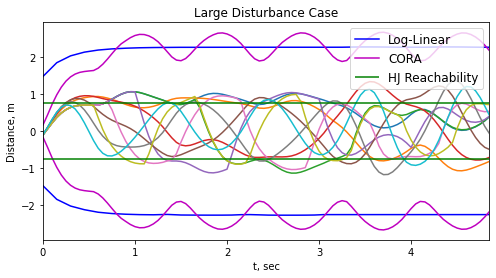

In [119]:
freq = [0.1, 0.3, 0.5, 0.7, 0.9]#, 1.1, 1.3, 1.5]
dist = ['square', 'sine']
# t_vect2 = np.linspace(0,t_vect[-1],len(t_vect))
w1l = 5
w2l = .1
plt.figure(figsize=(8,4))
# e = np.array([0.1,0.1,np.pi/100]) # Lie Group
# e0 = SE2(e[0], e[1], e[2]).log.vee # Lie Algebra
# omega0 = 0
# R1 = []
# R2 = []
# ly_val = []
# sol = find_se2_invariant_set(-np.pi/2, np.pi/2)
# zeta = iteration(w1l, w2l, e0, 0, sol)
# v1 = sv1(zeta[2])
# v2 = sv2(zeta[0], zeta[1],zeta[2])
# w1 = v1*w1l + v2*w2l
# w2 = w2l
for i, f in enumerate(freq):
    for d in dist:
        res = simulate_rover(planner, f, w1l, w2l, -0.1, -0.1, -np.pi/100, 20, case='', dist = d, dt=.05, use_approx = False)
        y_vect = res['y']
        x, y, theta, x_r, y_r, theta_r, log_e_x, log_e_y, log_e_theta = [y_vect[i, :] for i in range(len(y_vect))]
        err = np.array([compute_err(y[3], y[4], y[5], y[0], y[1], y[2]) for y in y_vect.T]).T
        err_y = err[1,:]
        err_x = err[0,:]
        plt.rcParams.update({'font.size': 10})
        plt.plot(res['t'], err_y)

plt.plot(t_vect,  bound_y1l, 'b')
plt.plot(t_vect,  bound_y2l, 'b', label='Log-Linear')
plt.plot(t_vect2, bound, 'm')
plt.plot(t_vect2, -bound, 'm', label='CORA')
plt.hlines(0.75, 0, t_vect[-1], color='green')
plt.hlines(-0.75, 0, t_vect[-1], color='green', label='HJ Reachability')
plt.legend(loc=1, prop={'size': 12})
plt.xlabel('t, sec')
plt.ylabel('Distance, m')
plt.title('Large Disturbance Case')
plt.xlim(0, t_vect[-1])
plt.savefig('bound2.eps', format='eps', bbox_inches='tight')

# No Sideslip

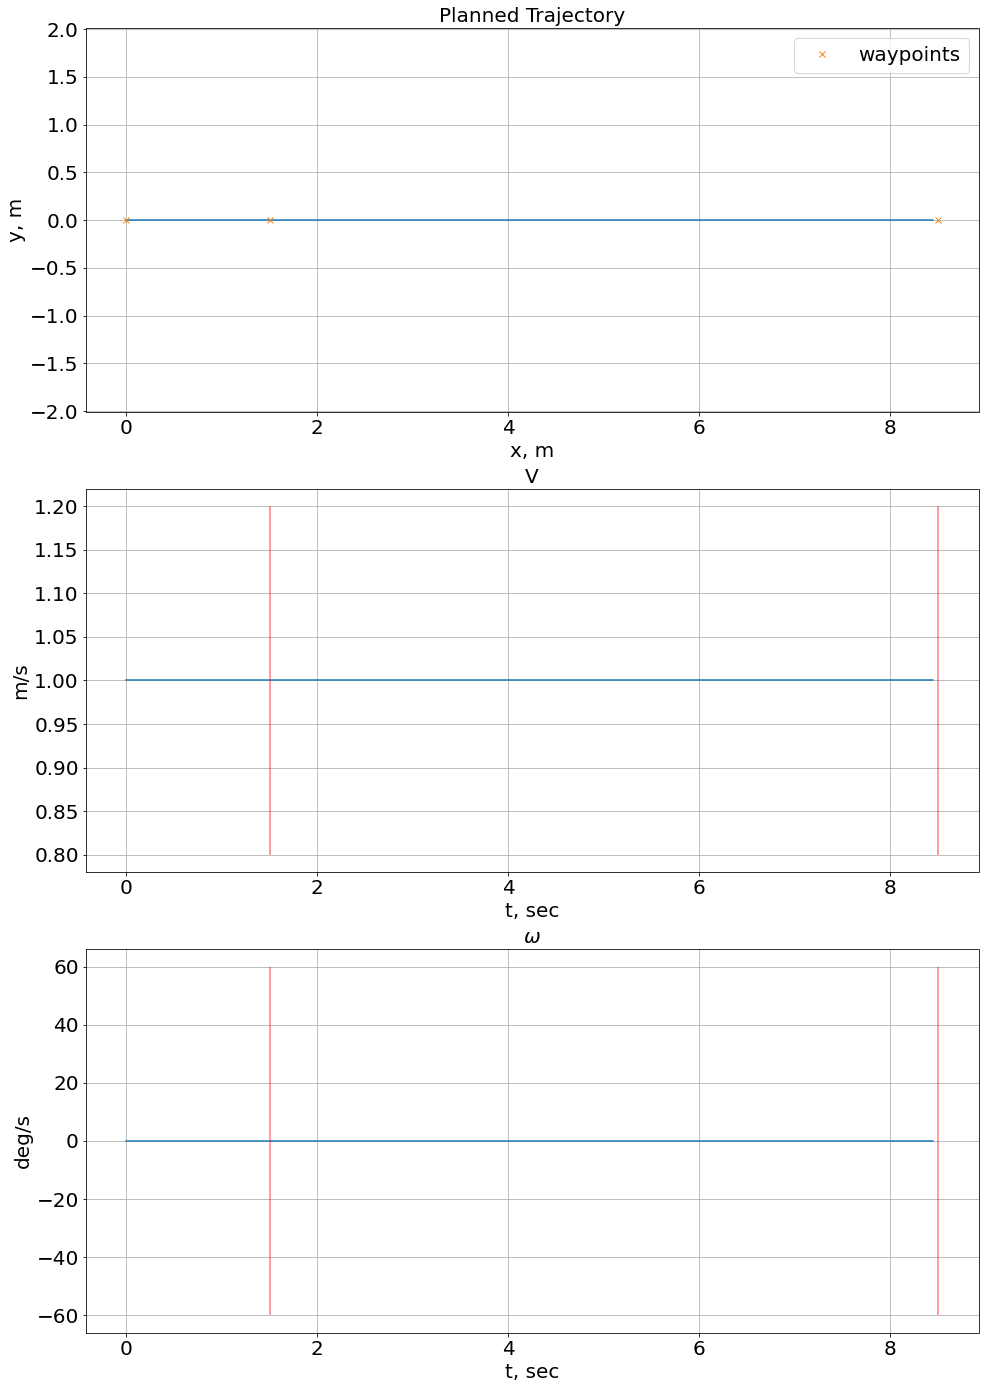

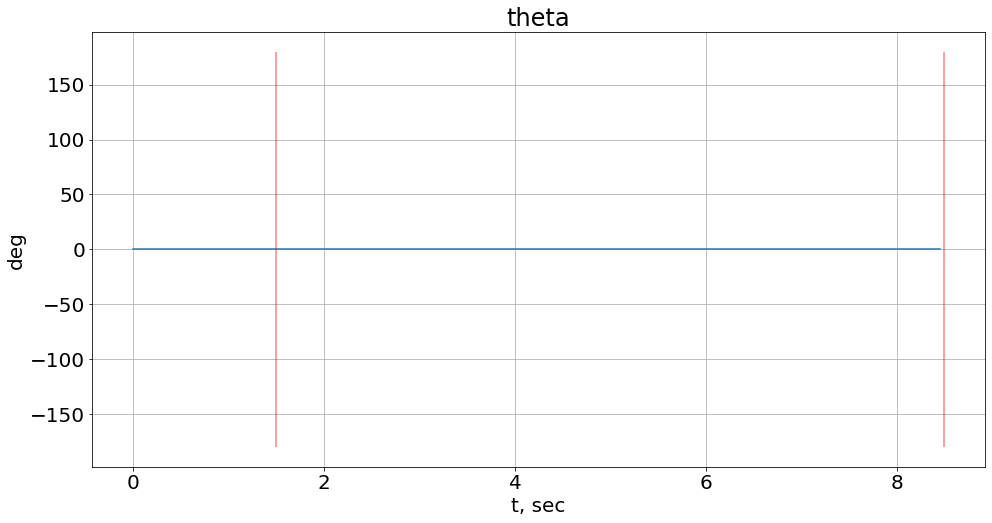

In [681]:
v  =  1 # m/s
r = 1.5
planner = RoverPlanner(x=0, y=0, v=v, theta=0, r=r)
# planner.goto(15, 0, v, r)
planner.goto(10, 0, v, r)
# planner.goto(30, 15, v, r)
# planner.goto(5, 5, v, r)
# planner.goto(10, 5, v, r)
# planner.goto(10, 0, v, r)
# planner.goto(5, 0, v, r)
# planner.goto(-20, 20, v, r)
# planner.goto(0, 6, v, r)
# planner.goto(0, 12, v, r)
# planner.goto(6, 12, v, r)
# planner.goto(6, 6, v, r)
# planner.goto(-6, 6, v, r)
# planner.goto(-6, 12, v, r)
#planner.stop(-100, 100)
""
ref_data = planner.compute_ref_data(plot=True)
x_r = ref_data['way_points'][0,:]
y_r = ref_data['way_points'][1,:]
omega = ref_data['omega']
ref_theta = ref_data['theta']    

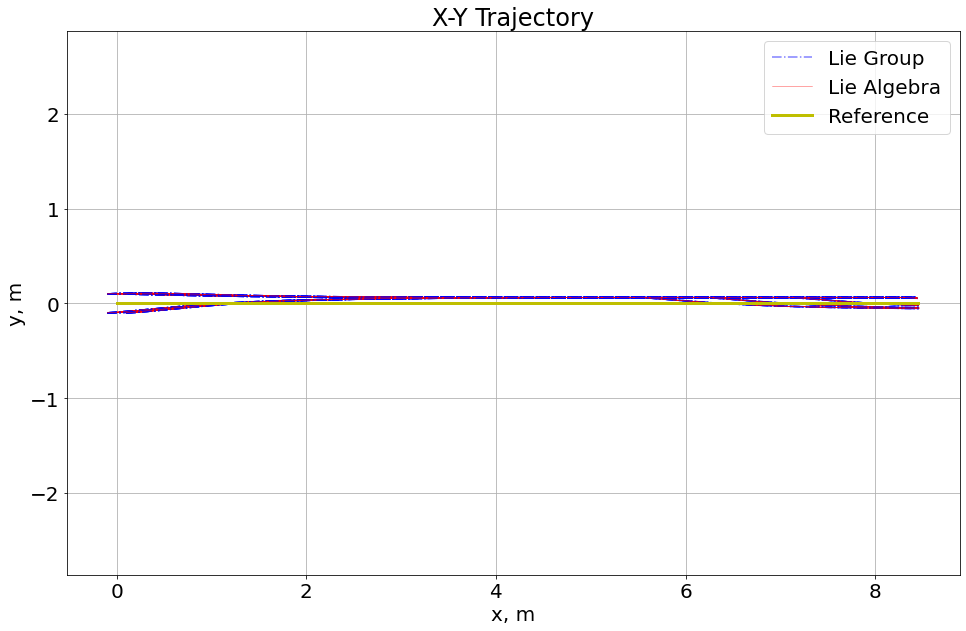

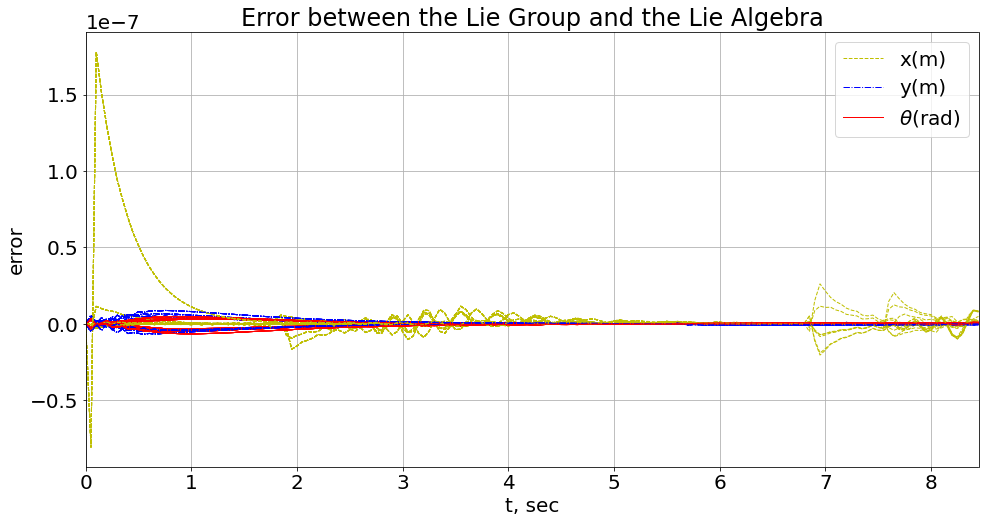

In [609]:
freq = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]#, 0.9, 1.3]#, .04, .06, .08] # freq = 0.02 not happy with L=diag([1,0,1])
res = []
t = 40
# disturbances
w1s = .05
w2 = .05
e = np.array([[],[],[]])
vr = 1

cnt = 0
for theta0 in np.linspace(-np.pi/100, np.pi/100, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
            cnt += 1
            for i, f in enumerate(freq):
                res = simulate_rover(planner, freq_d=f, w1=w1s, w2=w2, x0=x0, y0=y0, theta0=theta0, vr=vr, dist='square', case='no_side', dt=.05, use_approx=False)
                legend = cnt == 1 and f == freq[-1]
                fig1, fig2, err = plot_sim_corres(res, planner, name='', legend=legend, save=False)
                es = np.append(e, err, axis=1)

# fig1.savefig('Lie_corres.eps', format='eps', bbox_inches='tight')
# fig2.savefig('Lie_error2.eps', format='eps', bbox_inches='tight')

In [610]:
E0 = np.array([.1,.1,np.pi/100]) # Lie Group
e0 = SE2(E0[0], E0[1], E0[2]).log.vee # Lie Algebra
t = 0
omega = np.deg2rad(0)
sols = find_se2_invariant_set(-omega, omega, 1, 1, es, case='no_side')
P = sols['P']
beta = (e0.T@P@e0)

[[1.6317417622658436e-08, 0.0032768970940664738], [-0.0025478451016892408, 0.001031013943273312], [-0.0032553201104636594, 0.0013173015979192815], [-0.049664770860848105, 0.10174340480249851], [-0.01785535249247442, 0.16218751711744606], [0.9771866476460315, 1.207223070895692]]
-0.7876493483510312


In [611]:
w1s = .05 # small: 1 large: 5 (m/s)
w2 = .05 # small: 0.1 large: .1 (rad/s)
w1s_new = iteration(w1s, w2, beta, t, sols)
print(w1s_new)

0.06427928489708107


In [612]:
points, _ = se2_lie_algebra_invariant_set_points(sols, 10, w1s_new, w2, beta) #Lie Algebra
inv_points = np.zeros((3,points.shape[1]))
for i in range(points.shape[1]):
    exp_points = se2(points[0,i], points[1,i], points[2,i]).exp
    inv_points[:,i] = np.array([exp_points.x, exp_points.y, exp_points.theta])

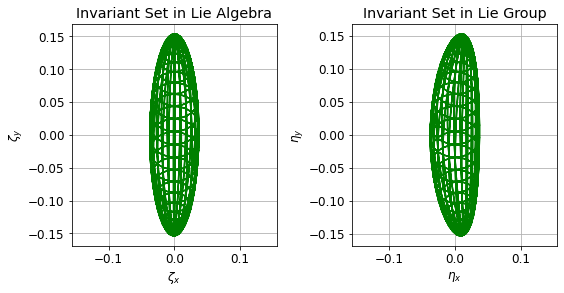

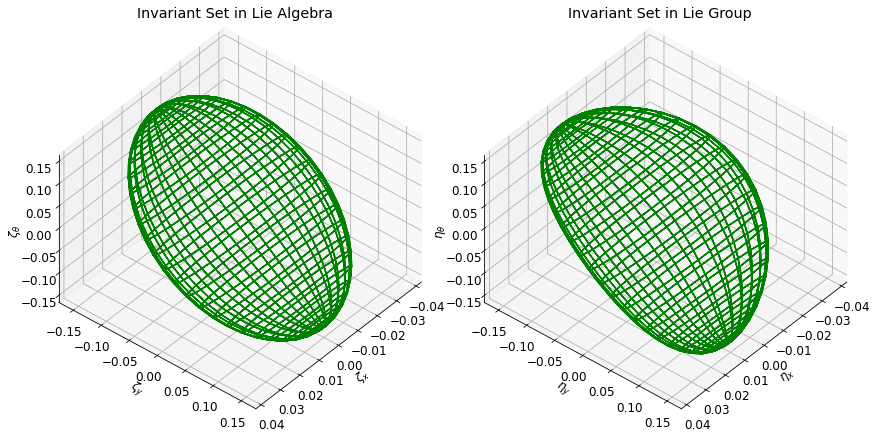

In [613]:
plt.figure(figsize=(8,4))
plt.rcParams.update({'font.size': 12})
ax = plt.subplot(121)
ax.plot(points[0, :], points[1, :], 'g')
ax.set_xlabel('$\\zeta_x$')
ax.set_ylabel('$\\zeta_y$')
# ax.plot(xopt.x,xopt.y,'ro')
plt.axis('equal')
plt.grid(True)
ax2 = plt.subplot(122)
ax2.plot(inv_points[0, :-1], inv_points[1, :-1], 'g')
# ax2.plot(e[0],e[1],'ro')
ax2.set_xlabel('$\\eta_x$')
ax2.set_ylabel('$\\eta_y$')
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
ax.set_title('Invariant Set in Lie Algebra')
ax2.set_title('Invariant Set in Lie Group')
plt.savefig('figures/Invariant_ns_st_s.eps', format='eps', bbox_inches='tight')


plt.figure(figsize=(12,6))
ax = plt.subplot(121, projection='3d', proj_type='ortho', elev=40, azim=40)
# ax.plot3D(e0[0], e0[1], e0[2], 'ro');
ax.plot3D(points[0, :], points[1, :], points[2, :],'g');
ax.set_xlabel('$\\zeta_x$')
ax.set_ylabel('$\\zeta_y$')
ax.set_zlabel('$\\zeta_\\theta$')
ax.set_title('Invariant Set in Lie Algebra')
plt.axis('auto')
ax2 = plt.subplot(122, projection='3d', proj_type='ortho', elev=40, azim=40)
# ax2.plot3D(e[0], e[1], e[2], 'ro');
ax2.plot3D(inv_points[0, :], inv_points[1, :], inv_points[2, :], 'g');
# ax2.plot3D(e[0], e[1], e[2], 'ro');
ax2.set_xlabel('$\\eta_x$')
ax2.set_ylabel('$\\eta_y$')
ax2.set_zlabel('$\\eta_\\theta$')
ax2.set_title('Invariant Set in Lie Group')
plt.axis('auto')
plt.tight_layout()
plt.savefig('figures/Invariant3d_ns_st_s.eps', format='eps', bbox_inches='tight')

In [614]:
n = 44# number of interval hulls
flow_pipes_LMI1, intervalhull_LMI, nom, t_vect, bound_y1, bound_y2 = flowpipes(planner, n, beta, w1s, w2, sols)

[[-0.1       ]
 [-0.1       ]
 [-0.03141593]]
[-0.09842098 -0.10156257 -0.03141593]


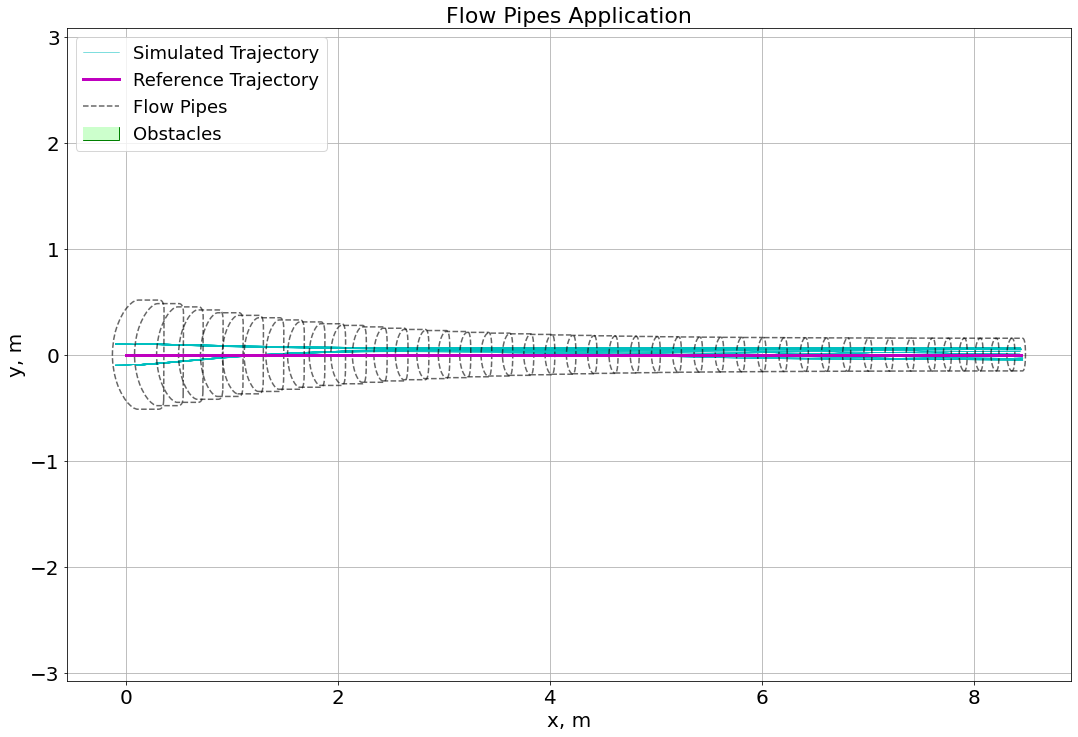

In [615]:
# small distrubance
freq = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]#, 0.07, 0.09]#, 1, 1.1, 1.3, 1.5]#, 1.2, 1.3, 1.4, 1.5]#,0.04,0.05
e = []
V = []
# number of interval hulls
# disturbances

cnt = 0
for theta0 in np.arange(-np.pi/100, np.pi/100, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
            cnt += 1
            init_e = np.array([[x0, y0, theta0]]).T
            V0 = init_e.T@sols['P']@init_e
            V.append(V0)
            e.append(init_e)
            for i, f in enumerate(freq):
                res = simulate_rover(planner, f, w1s, w2, x0, y0, theta0, vr, dist='sine', case='no_side', dt=.05, use_approx = False)
                res1 = simulate_rover(planner, f, w1s, w2, x0, y0, theta0, vr, dist='square', case='no_side', dt=.05, use_approx = False)
                legend = cnt == 1 and i == 0
                plot_rover_simulated(res, planner, name='', legend=legend, save=False, linewidth = .5, color = 'c')
                plot_rover_simulated(res1, planner, name=' in square wave', legend=False, save=False, linewidth = .5, color = 'c')
                #if i == len(freq) - 1:
                    #r3 = simulate_rover(planner, f, w1, w2, 0, 0, theta0, dist='maxdV', sol= sol_s)
                    #plot_rover_simulated(r3, name='maxdV', legend= (cnt == 1), save=False, linewidth = 1, color = 'r')

i = np.array(V).argmax()
print(e[i])
e0 = SE2(e[i][0], e[i][1], e[i][2]).log.vee
print(e0)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI1[facet][:,0], flow_pipes_LMI1[facet][:,1], color='k', linestyle='--', alpha = 0.6)

# obs = P4.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)
# P3.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)
# P5.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)

h_nom = plt.plot(nom[:,0], nom[:,1], linewidth = 3, color='m', linestyle='-')

plt.axis('equal')
plt.title('Flow Pipes Application', fontsize=22)
plt.xlabel('x, m', fontsize=20)
plt.ylabel('y, m', fontsize=20)

lgd = plt.legend(loc=2, prop={'size': 18})
ax = lgd.axes
handles, labels = ax.get_legend_handles_labels()
handles.append(h_nom[0])
labels.append('Reference Trajectory')
handles.append(hs_ch_LMI[0])
labels.append('Flow Pipes')
handles.append(obs)
labels.append('Obstacles')
lgd._legend_box = None
lgd._init_legend_box(handles, labels)
lgd._set_loc(lgd._loc)
lgd.set_title(lgd.get_title().get_text())
plt.savefig('figures/flowpipe_ns_st_s.eps', format='eps', bbox_inches='tight')

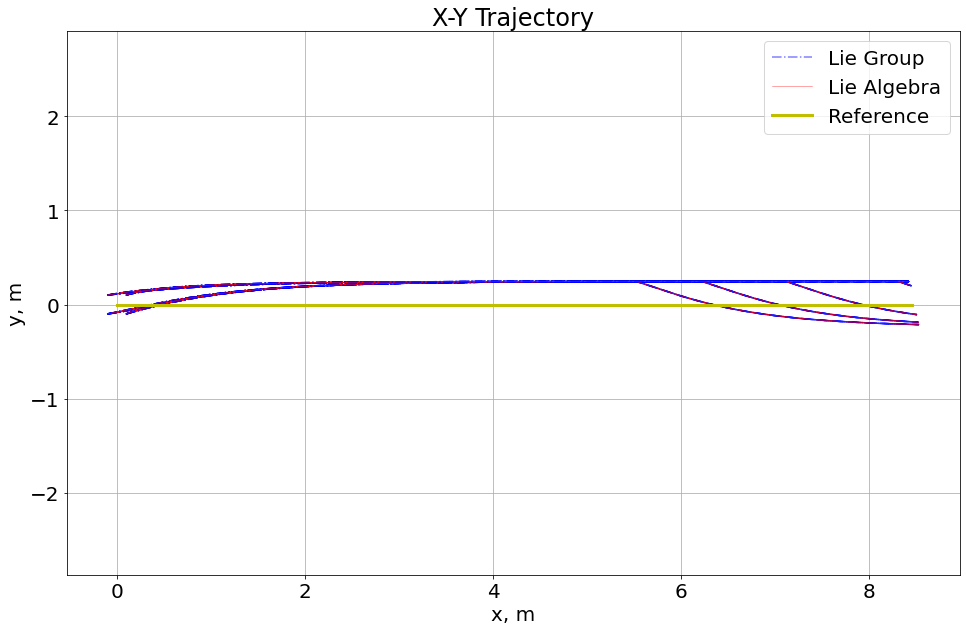

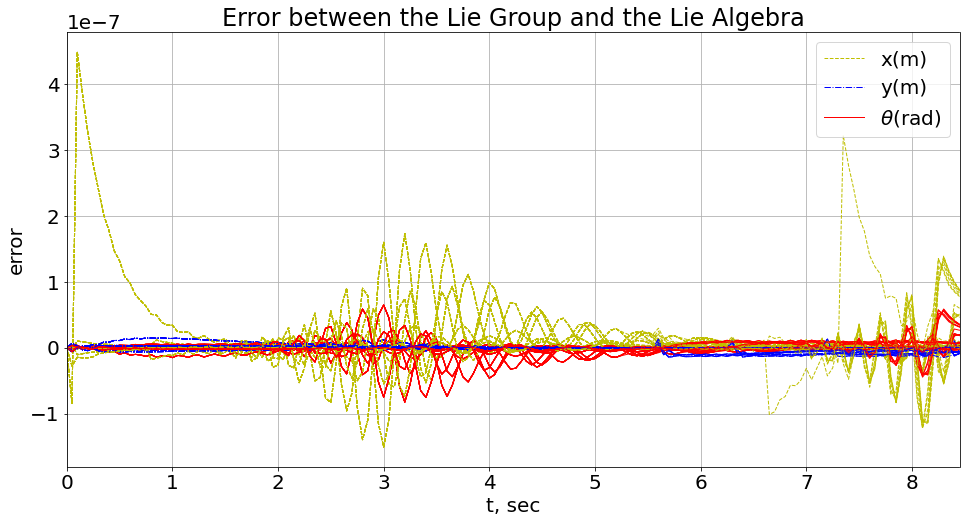

In [616]:
freq = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]#, 0.9, 1.3]#, .04, .06, .08] # freq = 0.02 not happy with L=diag([1,0,1])
res = []
t = 40
# disturbances
w1l = .25
w2 = .05
e = np.array([[],[],[]])
vr = 1

cnt = 0
for theta0 in np.linspace(-np.pi/100, np.pi/100, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
            cnt += 1
            for i, f in enumerate(freq):
                res = simulate_rover(planner, freq_d=f, w1=w1l, w2=w2, x0=x0, y0=y0, theta0=theta0, vr=vr, dist='square', case='no_side', dt=.05, use_approx=False)
                legend = cnt == 1 and f == freq[-1]
                fig1, fig2, err = plot_sim_corres(res, planner, name='', legend=legend, save=False)
                el = np.append(e, err, axis=1)

# fig1.savefig('Lie_corres.eps', format='eps', bbox_inches='tight')
# fig2.savefig('Lie_error2.eps', format='eps', bbox_inches='tight')

In [617]:
E0 = np.array([.1,.1,np.pi/100]) # Lie Group
e0 = SE2(E0[0], E0[1], E0[2]).log.vee # Lie Algebra
t = 0
omega = np.deg2rad(0)
sols = find_se2_invariant_set(-omega, omega, 1, 1, el, case='no_side')
P = sols['P']
beta = (e0.T@P@e0)

[[8.016585184270287e-06, 0.025654921793501966], [-0.008897992253914438, 0.0026567740134746855], [-0.011368749657392038, 0.003394495948473191], [-0.23921466492719481, 0.28367201315727275], [-0.1001171735777623, 0.16218751711744606], [0.8720827069375656, 1.207223070895692]]
-0.6496225610251052


In [618]:
w1l = .25 # small: 1 large: 5 (m/s)
w2 = .05 # small: 0.1 large: .1 (rad/s)
w1l_new = iteration(w1l, w2, beta, t, sols)
print(w1l_new)

0.26635683324361165


In [619]:
points, _ = se2_lie_algebra_invariant_set_points(sols, 10, w1l_new, w2, beta) #Lie Algebra
inv_points = np.zeros((3,points.shape[1]))
for i in range(points.shape[1]):
    exp_points = se2(points[0,i], points[1,i], points[2,i]).exp
    inv_points[:,i] = np.array([exp_points.x, exp_points.y, exp_points.theta])

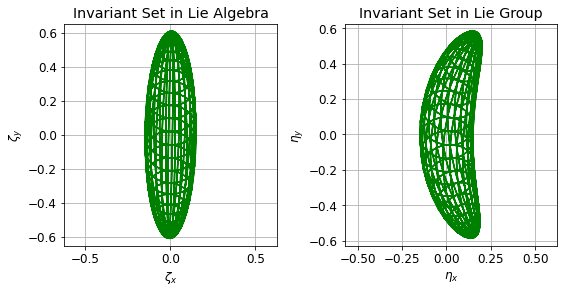

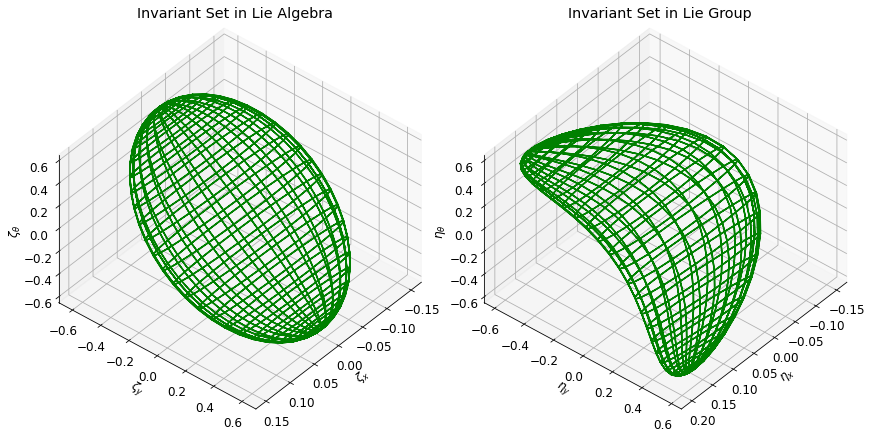

In [620]:
plt.figure(figsize=(8,4))
plt.rcParams.update({'font.size': 12})
ax = plt.subplot(121)
ax.plot(points[0, :], points[1, :], 'g')
ax.set_xlabel('$\\zeta_x$')
ax.set_ylabel('$\\zeta_y$')
# ax.plot(xopt.x,xopt.y,'ro')
plt.axis('equal')
plt.grid(True)
ax2 = plt.subplot(122)
ax2.plot(inv_points[0, :-1], inv_points[1, :-1], 'g')
# ax2.plot(e[0],e[1],'ro')
ax2.set_xlabel('$\\eta_x$')
ax2.set_ylabel('$\\eta_y$')
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
ax.set_title('Invariant Set in Lie Algebra')
ax2.set_title('Invariant Set in Lie Group')
plt.savefig('figures/Invariant_ns_st_l.eps', format='eps', bbox_inches='tight')


plt.figure(figsize=(12,6))
ax = plt.subplot(121, projection='3d', proj_type='ortho', elev=40, azim=40)
# ax.plot3D(e0[0], e0[1], e0[2], 'ro');
ax.plot3D(points[0, :], points[1, :], points[2, :],'g');
ax.set_xlabel('$\\zeta_x$')
ax.set_ylabel('$\\zeta_y$')
ax.set_zlabel('$\\zeta_\\theta$')
ax.set_title('Invariant Set in Lie Algebra')
plt.axis('auto')
ax2 = plt.subplot(122, projection='3d', proj_type='ortho', elev=40, azim=40)
# ax2.plot3D(e[0], e[1], e[2], 'ro');
ax2.plot3D(inv_points[0, :], inv_points[1, :], inv_points[2, :], 'g');
# ax2.plot3D(e[0], e[1], e[2], 'ro');
ax2.set_xlabel('$\\eta_x$')
ax2.set_ylabel('$\\eta_y$')
ax2.set_zlabel('$\\eta_\\theta$')
ax2.set_title('Invariant Set in Lie Group')
plt.axis('auto')
plt.tight_layout()
plt.savefig('figures/Invariant3d_ns_st_l.eps', format='eps', bbox_inches='tight')

In [621]:
n = 44# number of interval hulls
flow_pipes_LMI1, intervalhull_LMI, nom, t_vect, bound_y1, bound_y2 = flowpipes(planner, n, beta, w1l, w2, sols)

[[-0.1       ]
 [-0.1       ]
 [-0.03141593]]
[-0.09842098 -0.10156257 -0.03141593]


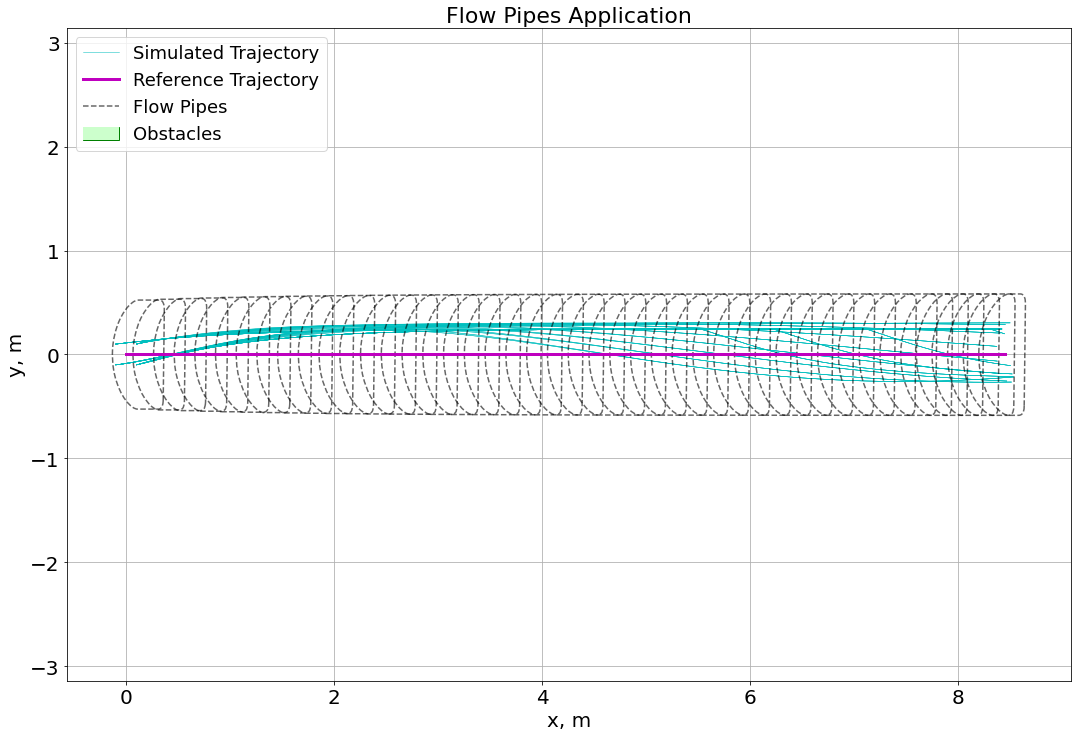

In [622]:
# small distrubance
freq = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]#, 0.07, 0.09]#, 1, 1.1, 1.3, 1.5]#, 1.2, 1.3, 1.4, 1.5]#,0.04,0.05
e = []
V = []
# number of interval hulls
# disturbances

cnt = 0
for theta0 in np.arange(-np.pi/100, np.pi/100, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
            cnt += 1
            init_e = np.array([[x0, y0, theta0]]).T
            V0 = init_e.T@sols['P']@init_e
            V.append(V0)
            e.append(init_e)
            for i, f in enumerate(freq):
                res = simulate_rover(planner, f, w1l, w2, x0, y0, theta0, vr, dist='sine', case='no_side', dt=.05, use_approx = False)
                res1 = simulate_rover(planner, f, w1l, w2, x0, y0, theta0, vr, dist='square', case='no_side', dt=.05, use_approx = False)
                legend = cnt == 1 and i == 0
                plot_rover_simulated(res, planner, name='', legend=legend, save=False, linewidth = .5, color = 'c')
                plot_rover_simulated(res1, planner, name=' in square wave', legend=False, save=False, linewidth = .5, color = 'c')
                #if i == len(freq) - 1:
                    #r3 = simulate_rover(planner, f, w1, w2, 0, 0, theta0, dist='maxdV', sol= sol_s)
                    #plot_rover_simulated(r3, name='maxdV', legend= (cnt == 1), save=False, linewidth = 1, color = 'r')

i = np.array(V).argmax()
print(e[i])
e0 = SE2(e[i][0], e[i][1], e[i][2]).log.vee
print(e0)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI1[facet][:,0], flow_pipes_LMI1[facet][:,1], color='k', linestyle='--', alpha = 0.6)

# obs = P4.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)
# P3.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)
# P5.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)

h_nom = plt.plot(nom[:,0], nom[:,1], linewidth = 3, color='m', linestyle='-')

plt.axis('equal')
plt.title('Flow Pipes Application', fontsize=22)
plt.xlabel('x, m', fontsize=20)
plt.ylabel('y, m', fontsize=20)

lgd = plt.legend(loc=2, prop={'size': 18})
ax = lgd.axes
handles, labels = ax.get_legend_handles_labels()
handles.append(h_nom[0])
labels.append('Reference Trajectory')
handles.append(hs_ch_LMI[0])
labels.append('Flow Pipes')
handles.append(obs)
labels.append('Obstacles')
lgd._legend_box = None
lgd._init_legend_box(handles, labels)
lgd._set_loc(lgd._loc)
lgd.set_title(lgd.get_title().get_text())
plt.savefig('figures/flowpipe_ns_st_l.eps', format='eps', bbox_inches='tight')

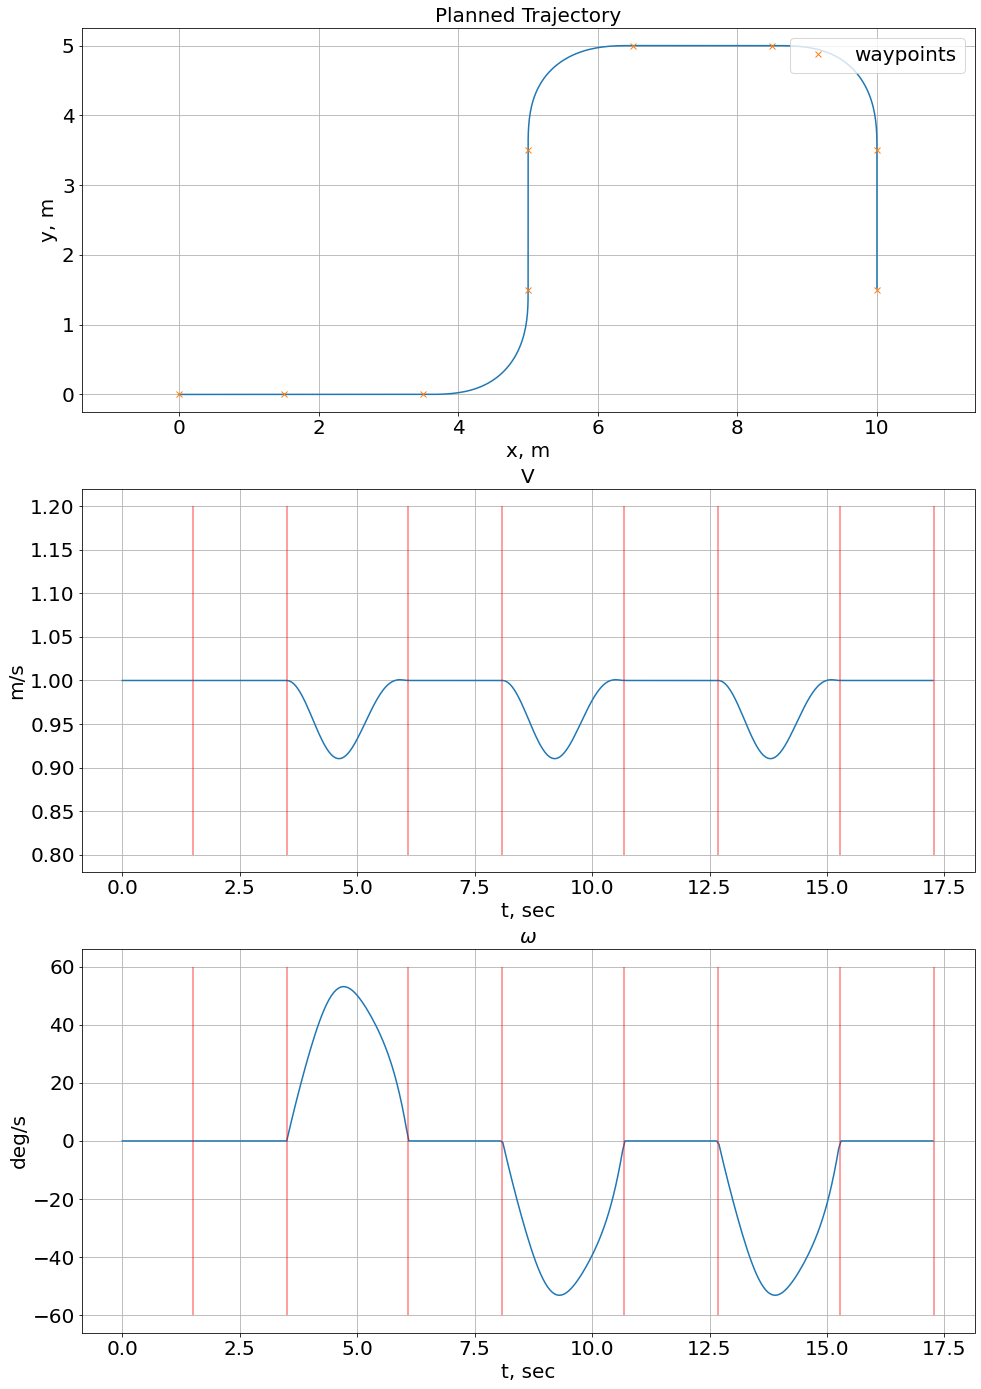

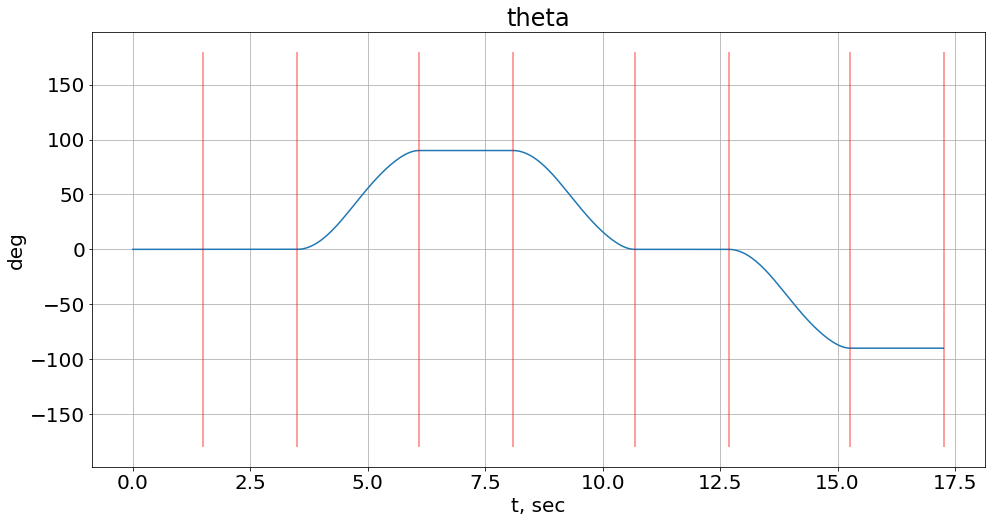

In [682]:
v  =  1 # m/s
r = 1.5
planner = RoverPlanner(x=0, y=0, v=v, theta=0, r=r)
# planner.goto(15, 0, v, r)
planner.goto(5, 0, v, r)
# planner.goto(30, 15, v, r)
planner.goto(5, 5, v, r)
planner.goto(10, 5, v, r)
planner.goto(10, 0, v, r)
# planner.goto(5, 0, v, r)
# planner.goto(-20, 20, v, r)
# planner.goto(0, 6, v, r)
# planner.goto(0, 12, v, r)
# planner.goto(6, 12, v, r)
# planner.goto(6, 6, v, r)
# planner.goto(-6, 6, v, r)
# planner.goto(-6, 12, v, r)
#planner.stop(-100, 100)
""
ref_data = planner.compute_ref_data(plot=True)
x_r = ref_data['way_points'][0,:]
y_r = ref_data['way_points'][1,:]
omega = ref_data['omega']
ref_theta = ref_data['theta']    

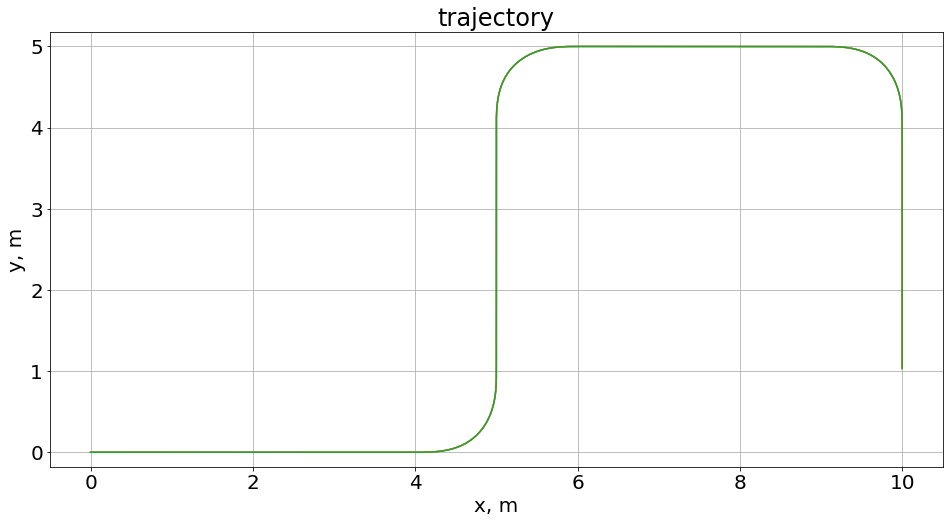

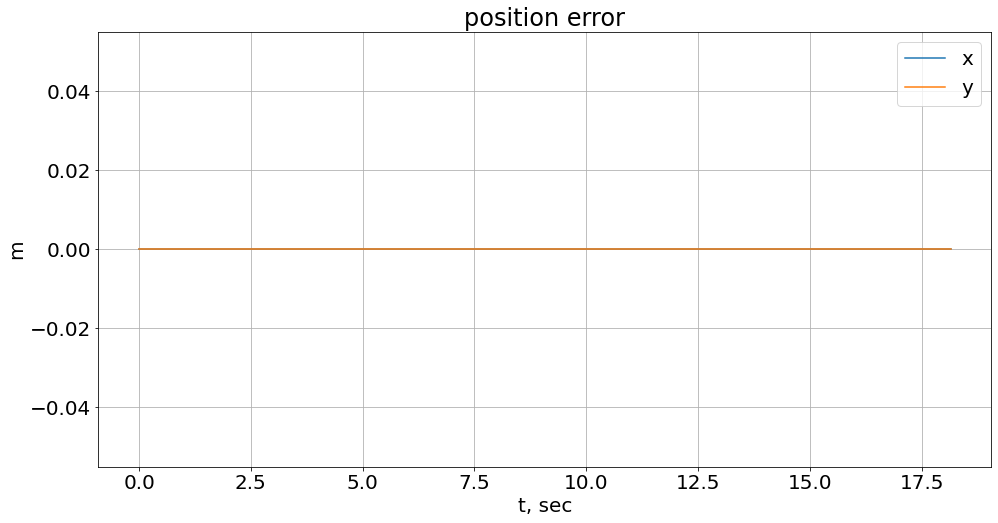

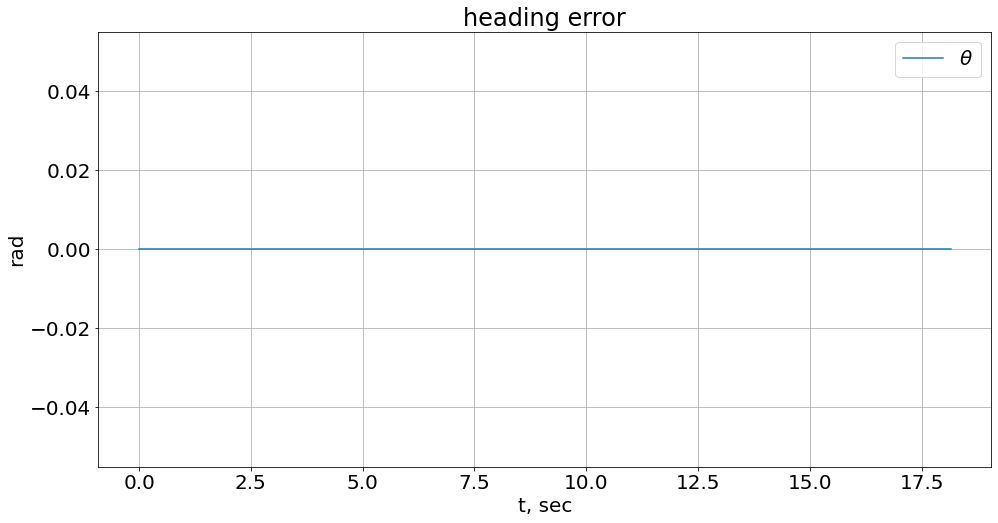

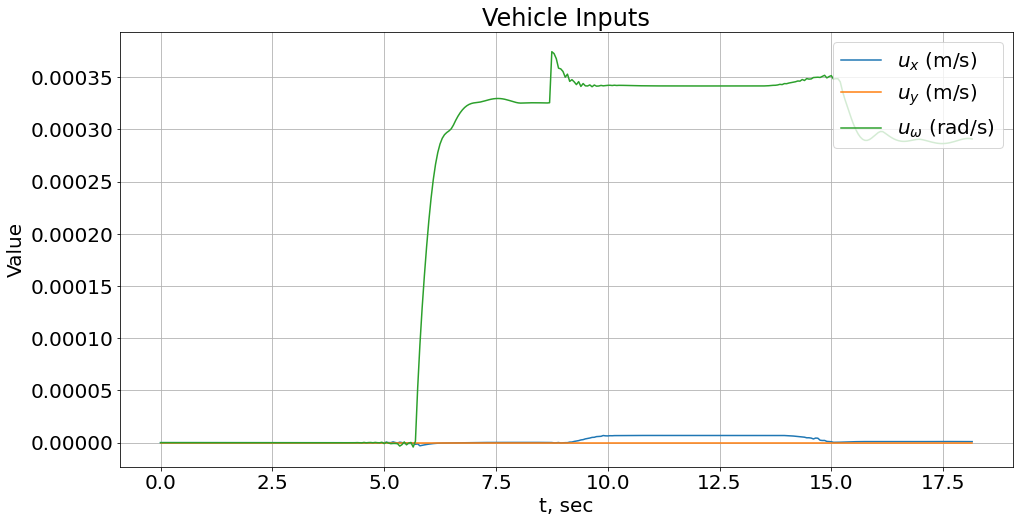

In [117]:
vr = 1
# res = simulate_rover(planner, freq_d=.015, w1=0.1, w2=0.1, x0=0, y0=0, theta0=np.pi/100, dist='sine', dt=.05, use_approx=False)
res = simulate_rover(planner, freq_d=.02, w1=0, w2=0, x0=0, y0=0, theta0=0, vr=1, dist='sine', case='no_side', dt=.05, use_approx=False)
err = plot_rover_sim(res=res, vr=vr, case='', planner=planner)

small disturbance

In [668]:
freq = [0.01, 0.02, 0.03]#, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]#, 0.9, 1.3]#, .04, .06, .08] # freq = 0.02 not happy with L=diag([1,0,1])
res = []
t = 40
# disturbances
w1s = .05
w2 = .05
e = np.array([[],[],[]])
vr = 1

cnt = 0
for theta0 in np.linspace(-np.pi/100, np.pi/100, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
            cnt += 1
            for i, f in enumerate(freq):
                res = simulate_rover(planner, freq_d=f, w1=w1s, w2=w2, x0=x0, y0=y0, theta0=theta0, vr=vr, dist='square', case='no_side', dt=.05, use_approx=False)
                legend = cnt == 1 and f == freq[-1]
                fig1, fig2, err = plot_sim_corres(res, planner, name='', legend=legend, save=False)
                es = np.append(e, err, axis=1)

# fig1.savefig('Lie_corres.eps', format='eps', bbox_inches='tight')
# fig2.savefig('Lie_error2.eps', format='eps', bbox_inches='tight')

KeyboardInterrupt: 

In [625]:
E0 = np.array([.1,.1,np.pi/100]) # Lie Group
e0 = SE2(E0[0], E0[1], E0[2]).log.vee # Lie Algebra
t = 0
omega = np.deg2rad(60)
sols = find_se2_invariant_set(-omega, omega, 0.9, 1, es, case='no_side')
P = sols['P']
beta = (e0.T@P@e0)

[[1.6605785136166018e-06, 0.0032768968415848847], [-0.0025478451016892408, 0.0010310120023689763], [-0.0032553201104636594, 0.0013172991180727192], [-0.049664770860848105, 0.10174340088529994], [-0.039440133480209985, 0.16218751711744606], [0.849608294635975, 1.207223070895692]]
-0.6212854147583862


In [626]:
w1s = .05 # small: 1 large: 5 (m/s)
w2 = .05 # small: 0.1 large: .1 (rad/s)
w1s_new = iteration(w1s, w2, beta, t, sols)
print(w1s_new)

0.0647031111753861


In [627]:
points, _ = se2_lie_algebra_invariant_set_points(sols, 10, w1s_new, w2, beta) #Lie Algebra
inv_points = np.zeros((3,points.shape[1]))
for i in range(points.shape[1]):
    exp_points = se2(points[0,i], points[1,i], points[2,i]).exp
    inv_points[:,i] = np.array([exp_points.x, exp_points.y, exp_points.theta])

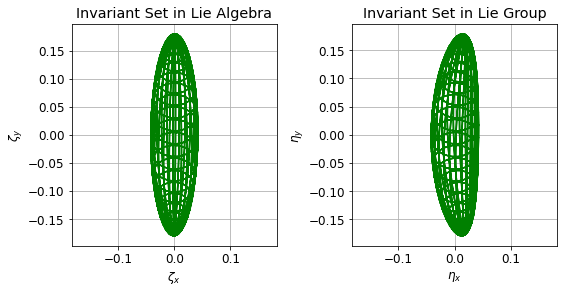

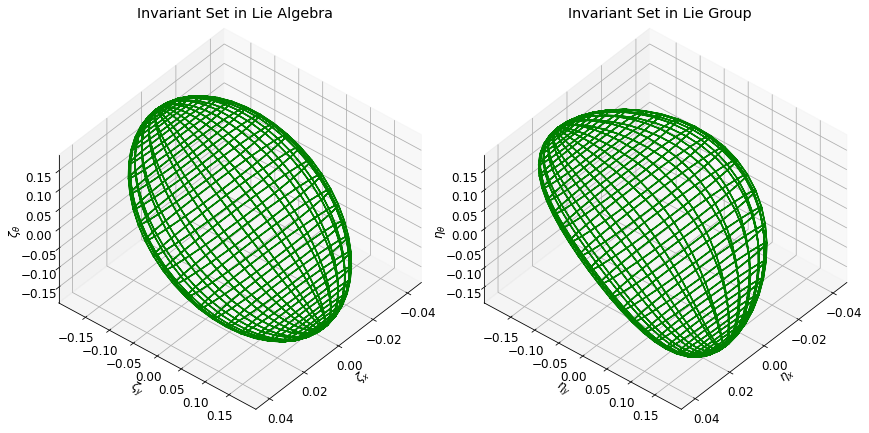

In [628]:
plt.figure(figsize=(8,4))
plt.rcParams.update({'font.size': 12})
ax = plt.subplot(121)
ax.plot(points[0, :], points[1, :], 'g')
ax.set_xlabel('$\\zeta_x$')
ax.set_ylabel('$\\zeta_y$')
# ax.plot(xopt.x,xopt.y,'ro')
plt.axis('equal')
plt.grid(True)
ax2 = plt.subplot(122)
ax2.plot(inv_points[0, :-1], inv_points[1, :-1], 'g')
# ax2.plot(e[0],e[1],'ro')
ax2.set_xlabel('$\\eta_x$')
ax2.set_ylabel('$\\eta_y$')
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
ax.set_title('Invariant Set in Lie Algebra')
ax2.set_title('Invariant Set in Lie Group')
plt.savefig('figures/Invariant_ns_s.eps', format='eps', bbox_inches='tight')


plt.figure(figsize=(12,6))
ax = plt.subplot(121, projection='3d', proj_type='ortho', elev=40, azim=40)
# ax.plot3D(e0[0], e0[1], e0[2], 'ro');
ax.plot3D(points[0, :], points[1, :], points[2, :],'g');
ax.set_xlabel('$\\zeta_x$')
ax.set_ylabel('$\\zeta_y$')
ax.set_zlabel('$\\zeta_\\theta$')
ax.set_title('Invariant Set in Lie Algebra')
plt.axis('auto')
ax2 = plt.subplot(122, projection='3d', proj_type='ortho', elev=40, azim=40)
# ax2.plot3D(e[0], e[1], e[2], 'ro');
ax2.plot3D(inv_points[0, :], inv_points[1, :], inv_points[2, :], 'g');
# ax2.plot3D(e[0], e[1], e[2], 'ro');
ax2.set_xlabel('$\\eta_x$')
ax2.set_ylabel('$\\eta_y$')
ax2.set_zlabel('$\\eta_\\theta$')
ax2.set_title('Invariant Set in Lie Group')
plt.axis('auto')
plt.tight_layout()
plt.savefig('figures/Invariant3d_ns_s.eps', format='eps', bbox_inches='tight')

In [629]:
n = 44# number of interval hulls
flow_pipes_LMI1, intervalhull_LMI, nom, t_vect, bound_y1, bound_y2 = flowpipes(planner, n, beta, w1s, w2, sols)

In [634]:
V2 = np.array([[0, 0], [1, 0], [1, 1], [0, 1]])
P2 = Polytope(V2)
p4 = (7, 3.8)
P3 = P2*1.5 - (-3.25,-2)
P4 = P2 + p4

P5 = 0.5*P3 + (1, -0.63)

[[-0.1       ]
 [-0.1       ]
 [-0.03141593]]
[-0.09842098 -0.10156257 -0.03141593]


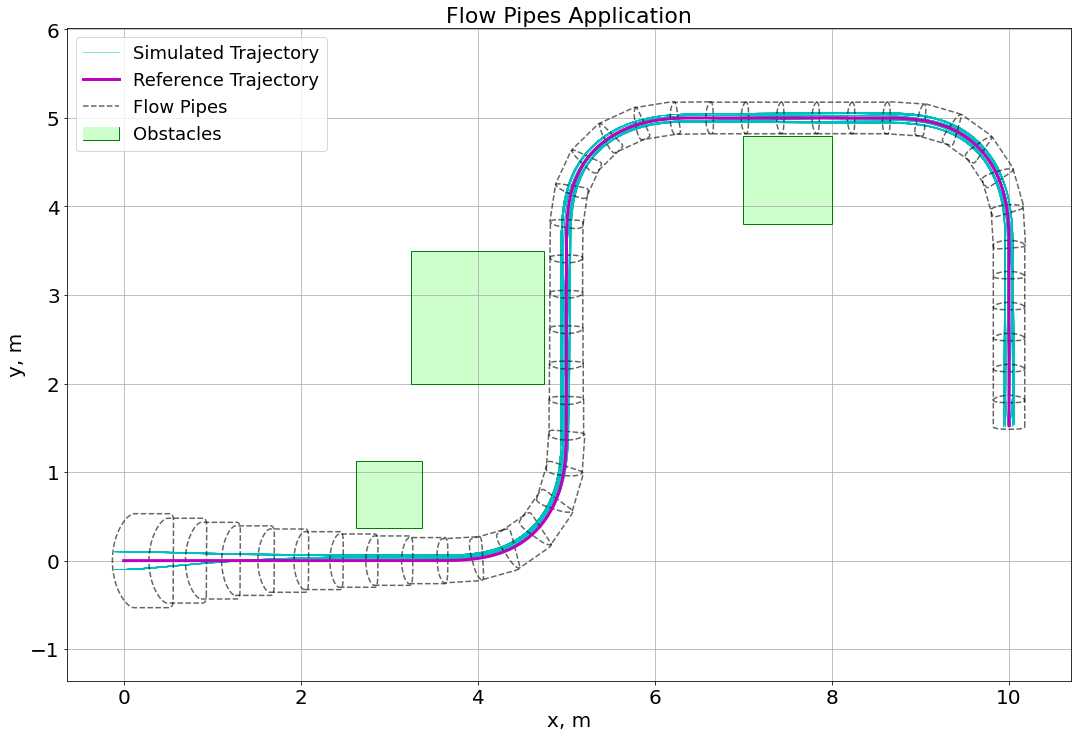

In [636]:
# small distrubance
freq = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]#, 0.07, 0.09]#, 1, 1.1, 1.3, 1.5]#, 1.2, 1.3, 1.4, 1.5]#,0.04,0.05
e = []
V = []
# number of interval hulls
# disturbances

cnt = 0
for theta0 in np.arange(-np.pi/100, np.pi/100, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
            cnt += 1
            init_e = np.array([[x0, y0, theta0]]).T
            V0 = init_e.T@sols['P']@init_e
            V.append(V0)
            e.append(init_e)
            for i, f in enumerate(freq):
                res = simulate_rover(planner, f, w1s, w2, x0, y0, theta0, vr, dist='sine', case='no_side', dt=.05, use_approx = False)
                res1 = simulate_rover(planner, f, w1s, w2, x0, y0, theta0, vr, dist='square', case='no_side', dt=.05, use_approx = False)
                legend = cnt == 1 and i == 0
                plot_rover_simulated(res, planner, name='', legend=legend, save=False, linewidth = .5, color = 'c')
                plot_rover_simulated(res1, planner, name=' in square wave', legend=False, save=False, linewidth = .5, color = 'c')
                #if i == len(freq) - 1:
                    #r3 = simulate_rover(planner, f, w1, w2, 0, 0, theta0, dist='maxdV', sol= sol_s)
                    #plot_rover_simulated(r3, name='maxdV', legend= (cnt == 1), save=False, linewidth = 1, color = 'r')

i = np.array(V).argmax()
print(e[i])
e0 = SE2(e[i][0], e[i][1], e[i][2]).log.vee
print(e0)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI1[facet][:,0], flow_pipes_LMI1[facet][:,1], color='k', linestyle='--', alpha = 0.6)

obs = P4.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)
P3.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)
P5.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)

h_nom = plt.plot(nom[:,0], nom[:,1], linewidth = 3, color='m', linestyle='-')

plt.axis('equal')
plt.title('Flow Pipes Application', fontsize=22)
plt.xlabel('x, m', fontsize=20)
plt.ylabel('y, m', fontsize=20)

lgd = plt.legend(loc=2, prop={'size': 18})
ax = lgd.axes
handles, labels = ax.get_legend_handles_labels()
handles.append(h_nom[0])
labels.append('Reference Trajectory')
handles.append(hs_ch_LMI[0])
labels.append('Flow Pipes')
handles.append(obs)
labels.append('Obstacles')
lgd._legend_box = None
lgd._init_legend_box(handles, labels)
lgd._set_loc(lgd._loc)
lgd.set_title(lgd.get_title().get_text())
plt.savefig('figures/flowpipe_ns_s.eps', format='eps', bbox_inches='tight')

large disturbance

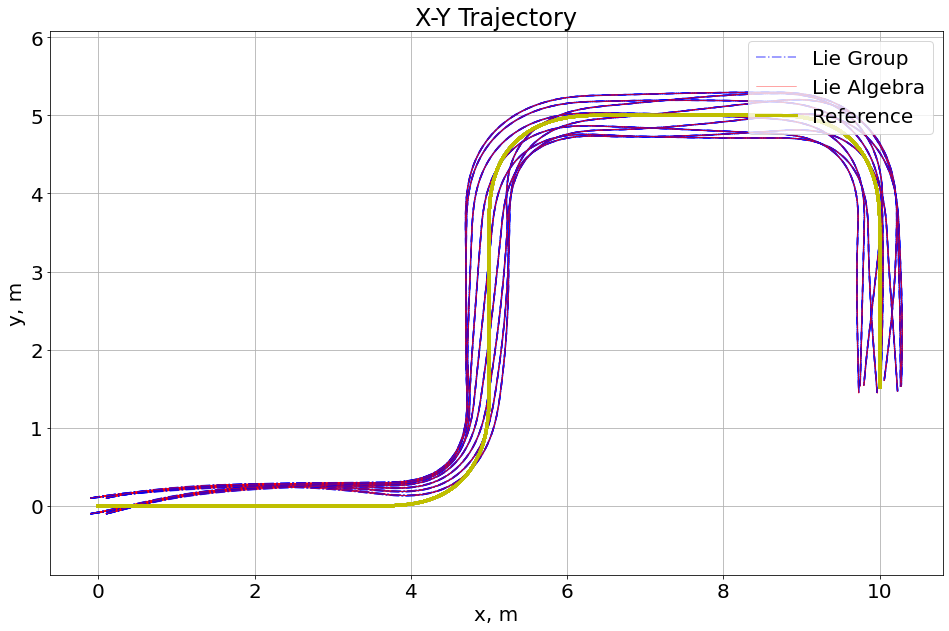

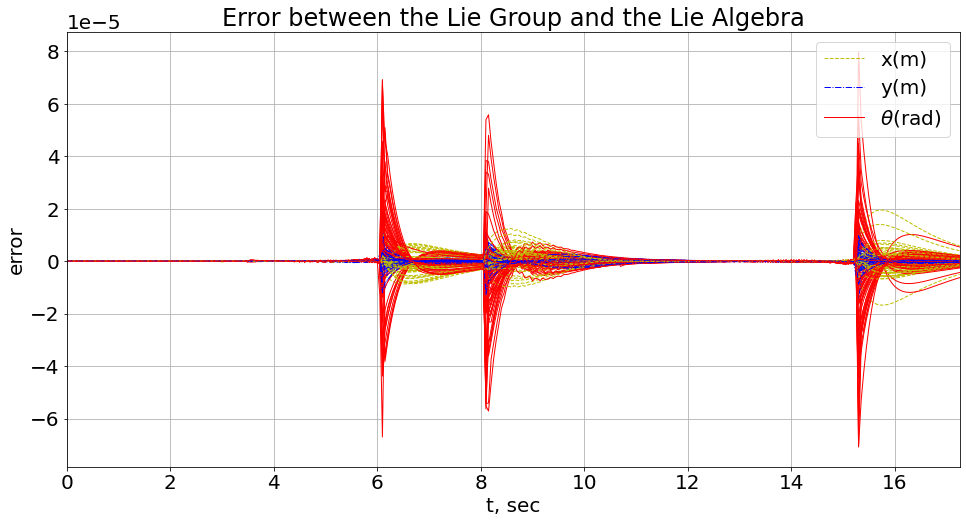

In [661]:
freq = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]#, 0.9, 1.3]#, .04, .06, .08] # freq = 0.02 not happy with L=diag([1,0,1])
res = []
t = 40
# disturbances
w1l = .25
w2 = .05
e = np.array([[],[],[]])
vr = 1

cnt = 0
for theta0 in np.linspace(-np.pi/100, np.pi/100, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
            cnt += 1
            for i, f in enumerate(freq):
                res = simulate_rover(planner, f, w1l, w2, x0, y0, theta0, vr, dist='sine', case='no_side', dt=.05, use_approx = False)
                legend = cnt == 1 and f == freq[-1]
                fig1, fig2, err = plot_sim_corres(res, planner, name='', legend=legend, save=False)
                el = np.append(e, err, axis=1)

# fig1.savefig('Lie_corres.eps', format='eps', bbox_inches='tight')
# fig2.savefig('Lie_error2.eps', format='eps', bbox_inches='tight')

In [662]:
E0 = np.array([.1,.1,np.pi/100]) # Lie Group
e0 = SE2(E0[0], E0[1], E0[2]).log.vee # Lie Algebra
t = 0
omega = np.deg2rad(60)
soll = find_se2_invariant_set(-omega, omega, 0.9, 1, el, case='no_side')
P = soll['P']
beta = (e0.T@P@e0)

[[2.384489393974482e-06, 0.04151536560628562], [-0.019393397650149257, 0.004466843220041598], [-0.024778475480669037, 0.005707177628203876], [-0.3286421654545539, 0.35994386733079964], [-0.19802850091585475, 0.16704134111421298], [0.6469837703049734, 1.2134246845098204]]
-0.3802449268629311


In [663]:
w1l = 0.25
w2 = 0.05
w1l_new = iteration(w1l, w2, beta, t, soll)
print(w1l_new)

0.26693674521730176


In [664]:
points, _ = se2_lie_algebra_invariant_set_points(soll, 10, w1l_new, w2, beta) #Lie Algebra
inv_points = np.zeros((3,points.shape[1]))
for i in range(points.shape[1]):
    exp_points = se2(points[0,i], points[1,i], points[2,i]).exp
    inv_points[:,i] = np.array([exp_points.x, exp_points.y, exp_points.theta])

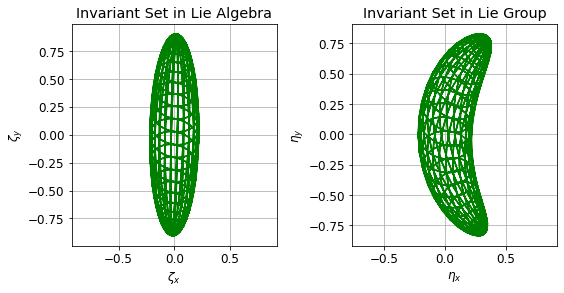

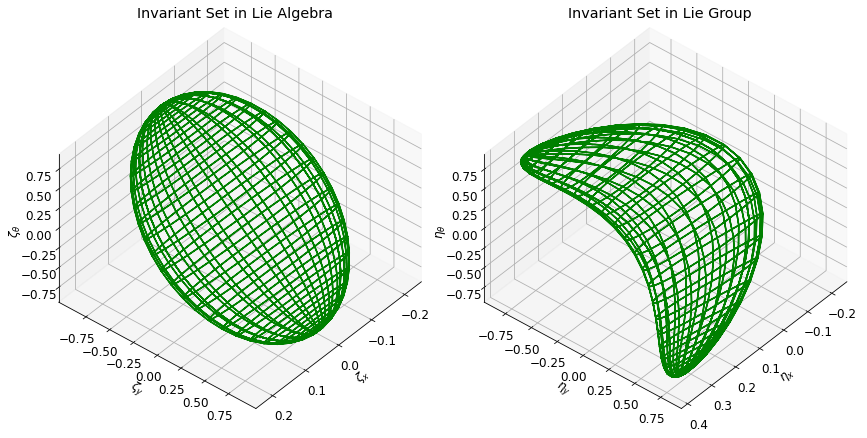

In [665]:
plt.figure(figsize=(8,4))
plt.rcParams.update({'font.size': 12})
ax = plt.subplot(121)
ax.plot(points[0, :], points[1, :], 'g')
ax.set_xlabel('$\\zeta_x$')
ax.set_ylabel('$\\zeta_y$')
# ax.plot(xopt.x,xopt.y,'ro')
plt.axis('equal')
plt.grid(True)
ax2 = plt.subplot(122)
ax2.plot(inv_points[0, :-1], inv_points[1, :-1], 'g')
# ax2.plot(e[0],e[1],'ro')
ax2.set_xlabel('$\\eta_x$')
ax2.set_ylabel('$\\eta_y$')
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
ax.set_title('Invariant Set in Lie Algebra')
ax2.set_title('Invariant Set in Lie Group')
plt.savefig('figures/Invariant_ns_l.eps', format='eps', bbox_inches='tight')


plt.figure(figsize=(12,6))
ax = plt.subplot(121, projection='3d', proj_type='ortho', elev=40, azim=40)
# ax.plot3D(e0[0], e0[1], e0[2], 'ro');
ax.plot3D(points[0, :], points[1, :], points[2, :],'g');
ax.set_xlabel('$\\zeta_x$')
ax.set_ylabel('$\\zeta_y$')
ax.set_zlabel('$\\zeta_\\theta$')
ax.set_title('Invariant Set in Lie Algebra')
plt.axis('auto')
ax2 = plt.subplot(122, projection='3d', proj_type='ortho', elev=40, azim=40)
# ax2.plot3D(e[0], e[1], e[2], 'ro');
ax2.plot3D(inv_points[0, :], inv_points[1, :], inv_points[2, :], 'g');
# ax2.plot3D(e[0], e[1], e[2], 'ro');
ax2.set_xlabel('$\\eta_x$')
ax2.set_ylabel('$\\eta_y$')
ax2.set_zlabel('$\\eta_\\theta$')
ax2.set_title('Invariant Set in Lie Group')
plt.axis('auto')
plt.tight_layout()
plt.savefig('figures/Invariant3d_ns_l.eps', format='eps', bbox_inches='tight')

In [666]:
n = 44# number of interval hulls
flow_pipes_LMI2, intervalhull_LMI, nom, t_vect, bound_y1, bound_y2 = flowpipes(planner, n, beta, w1l, w2, soll)

[[-0.1       ]
 [-0.1       ]
 [-0.03141593]]
[-0.09842098 -0.10156257 -0.03141593]


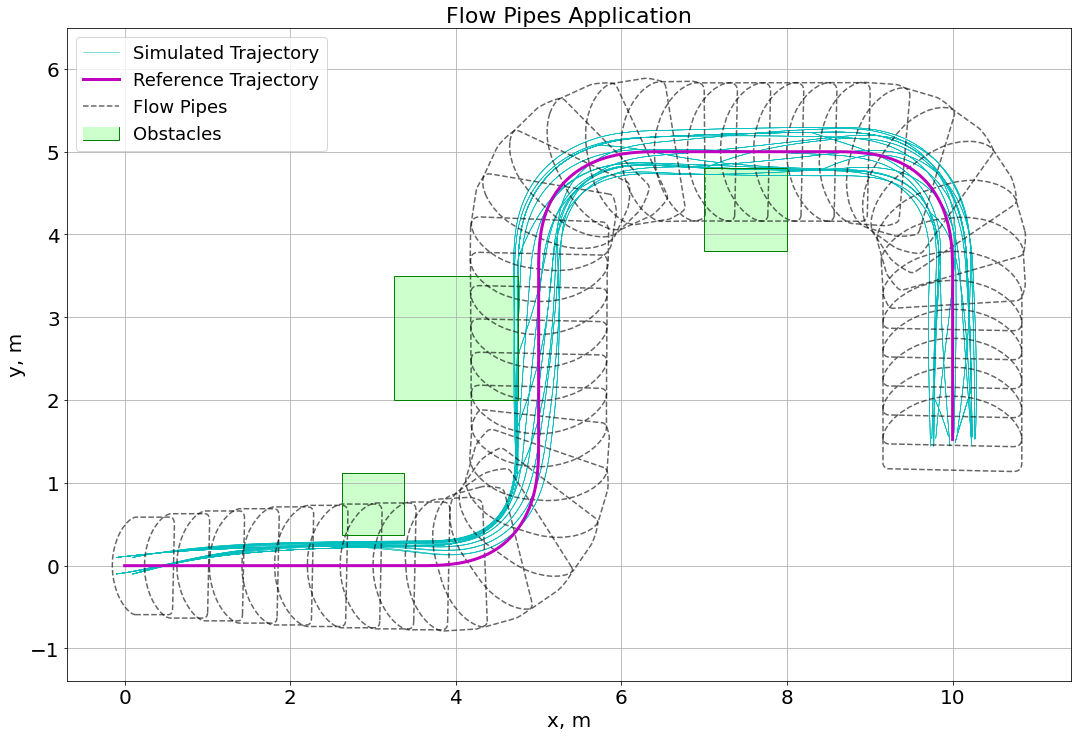

In [667]:
# small distrubance
freq = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]#, 1, 1.1, 1.3, 1.5]#, 1.2, 1.3, 1.4, 1.5]#,0.04,0.05
e = []
V = []
# number of interval hulls
# disturbances

cnt = 0
for theta0 in np.arange(-np.pi/100, np.pi/100, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
            cnt += 1
            init_e = np.array([[x0, y0, theta0]]).T
            V0 = init_e.T@sols['P']@init_e
            V.append(V0)
            e.append(init_e)
            for i, f in enumerate(freq):
                res = simulate_rover(planner, f, w1l, w2, x0, y0, theta0, vr, dist='sine', case='no_side', dt=.05, use_approx = False)
                res1 = simulate_rover(planner, f, w1l, w2, x0, y0, theta0, vr, dist='square', case='no_side', dt=.05, use_approx = False)
                legend = cnt == 1 and i == 0
                plot_rover_simulated(res, planner, name='', legend=legend, save=False, linewidth = .5, color = 'c')
                plot_rover_simulated(res1, planner, name=' in square wave', legend=False, save=False, linewidth = .5, color = 'c')
                #if i == len(freq) - 1:
                    #r3 = simulate_rover(planner, f, w1, w2, 0, 0, theta0, dist='maxdV', sol= sol_s)
                    #plot_rover_simulated(r3, name='maxdV', legend= (cnt == 1), save=False, linewidth = 1, color = 'r')

i = np.array(V).argmax()
print(e[i])
e0 = SE2(e[i][0], e[i][1], e[i][2]).log.vee
print(e0)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI2[facet][:,0], flow_pipes_LMI2[facet][:,1], color='k', linestyle='--', alpha = 0.6)

obs = P4.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)
P3.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)
P5.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)

h_nom = plt.plot(nom[:,0], nom[:,1], linewidth = 3, color='m', linestyle='-')

plt.axis('equal')
plt.title('Flow Pipes Application', fontsize=22)
plt.xlabel('x, m', fontsize=20)
plt.ylabel('y, m', fontsize=20)

lgd = plt.legend(loc=2, prop={'size': 18})
ax = lgd.axes
handles, labels = ax.get_legend_handles_labels()
handles.append(h_nom[0])
labels.append('Reference Trajectory')
handles.append(hs_ch_LMI[0])
labels.append('Flow Pipes')
handles.append(obs)
labels.append('Obstacles')
lgd._legend_box = None
lgd._init_legend_box(handles, labels)
lgd._set_loc(lgd._loc)
lgd.set_title(lgd.get_title().get_text())
plt.savefig('figures/flowpipe_ns_l.eps', format='eps', bbox_inches='tight')